In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
import seaborn as sns
import math

from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

from scipy.sparse import issparse


# set figure size for better visibility
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

## LOAD COUNT MATRIX

In [ ]:
# matrix.mtx stored as (n_genes x n_cells).
adata = sc.read_mtx("../data/matrix.mtx") 

# Scanpy expect (n_cells x n_genes) --> transpose
adata = adata.T

## LOAD METADATA (BARCODES AND GENES)

In [ ]:
# Pandas to read the TSV files. 
# 'header=None' is important because raw outputs usually don't have column names.

## Load cell barcodes
# ==> "barcodes.tsv" has one column with IDs like "experiment_plate1_A13"
barcodes = pd.read_csv("../data/barcodes.tsv", header=None, sep="\t")

## Load gene names
genes = pd.read_csv("../data/features.tsv", header=None, sep="\t")

## Construct scanpy ANNDATA object

For the biological analysis we need labels in the matrix. AnnData (Annotated Data) of Scanpy have attributes such as:

.X: matrix with numbers (counts)

.var: Variables, a DataFrame where index are the gene names.

.obs: observations, i.e. DataFrame where index are the barcodes <experiment>_plate<nº>_<WellID> and columns are the metadata (plate, exp. contition, ...)

=> important after for identifying groups in UMAP: sc.pl.umap(adata, color=['plate', 'condition'])

=> also for correcting batch effects, e.g. grouping by plates in PCA: batch_key='plate' to differentiate 



In [4]:
# --- ASSEMBLE THE ANNDATA OBJECT ---

# Assign cell names to the observations index
# Ensures the length matches the matrix rows
if len(barcodes) == adata.n_obs:
    adata.obs_names = barcodes[0].values
    # Ensure names are unique
    adata.obs_names_make_unique()
else:
    print(f"Error: Matrix has {adata.n_obs} cells but barcodes file has {len(barcodes)} lines.")

# Assign gene names to the variables index
if len(genes) == adata.n_vars:
    adata.var_names = genes[0].values 
    adata.var_names_make_unique()
else:
    print(f"Error: Matrix has {adata.n_vars} genes but features file has {len(genes)} lines.")

# --- PARSE EXPERIMENTAL METADATA ---
# Extract barcode features (experiment, plate, ...) into separate columns.

# Extract the string index
ids = adata.obs.index.to_series()

# Split by underscore '_' (from right to left since experimentos can have '_' in the name)
#
# rsplit: cut from right (split from left)
# n=2: maximum 2 cuts 
# expand=True creates a DataFrame with one column per split part
split_ids = ids.str.rsplit('_', n=2, expand=True)

# Assign to new metadata columns in adata.obs
try:
    # Assuming format: Condition_Plate_WellID (3 parts)
    adata.obs['experiment'] = split_ids[0]  # e.g., "gld"
    adata.obs['plate'] = split_ids[1]      # e.g., "plate1"
    adata.obs['well_ID'] = split_ids[2]       # e.g., "A13"
except KeyError:
    print("Warning: Barcode format didn't match the expected 3 parts split.")

# --- DEFINITION OF WELL LISTS (Topology of the Plate) ---
# Lists provided by the user for standard plates
empty_wells = ['M24','N24','O24','P24']  
mESC_wells = [
    'A1','B1','C1','D1','E1','F1','G1','H1','I1','J1','K1','L1','M1','N1','O1','P1',
    'A2','B2','C2','D2','E2','F2','G2','H2','I2','J2','K2','L2','M2','N2','O2','P2',
    'A3','B3','C3','D3','E3','F3','G3','H3'
]

# Function to assign category based on well ID
def assign_sample_type(well_id):
    if well_id in empty_wells:
        return 'Empty'
    elif well_id in mESC_wells:
        return 'mESC'
    else:
        return 'Differentiated' # Default for others (Ectoderm, etc.)

# --- APPLY GLOBAL MAPPING ---

adata.obs['sample_type'] = adata.obs['well_ID'].apply(assign_sample_type)

# --- 3. VERIFICATION ---
print("--- Global Sample Type Counts ---")
print(adata.obs['sample_type'].value_counts())

# --- SAVE ---
print(f"\nFinal shape: {adata.shape}")
print("First 5 cells metadata:")
print(adata.obs.head())

# Save the assembled object
adata.write("raw_data_assembled.h5ad")

--- Global Sample Type Counts ---
sample_type
Differentiated    5262
Empty               56
Name: count, dtype: int64

Final shape: (5318, 244197)
First 5 cells metadata:
               experiment   plate well_ID     sample_type
gld_plate1_A06        gld  plate1     A06  Differentiated
gld_plate1_A07        gld  plate1     A07  Differentiated
gld_plate1_A08        gld  plate1     A08  Differentiated
gld_plate1_A09        gld  plate1     A09  Differentiated
gld_plate1_A10        gld  plate1     A10  Differentiated


Check format:

In [ ]:
adata.obs

experiment   plate well_ID     sample_type
gld_plate1_A06                    gld  plate1     A06  Differentiated
gld_plate1_A07                    gld  plate1     A07  Differentiated
gld_plate1_A08                    gld  plate1     A08  Differentiated
gld_plate1_A09                    gld  plate1     A09  Differentiated
gld_plate1_A10                    gld  plate1     A10  Differentiated
...                               ...     ...     ...             ...
mES_mesodiff_plate2_P20  mES_mesodiff  plate2     P20  Differentiated
mES_mesodiff_plate2_P21  mES_mesodiff  plate2     P21  Differentiated
mES_mesodiff_plate2_P22  mES_mesodiff  plate2     P22  Differentiated
mES_mesodiff_plate2_P23  mES_mesodiff  plate2     P23  Differentiated
mES_mesodiff_plate2_P24  mES_mesodiff  plate2     P24           Empty

[5318 rows x 4 columns]

In [ ]:
adata.var	

Empty DataFrame
Columns: []
Index: [4933401J01Rik, Gm26206, Xkr4, Gm18956, Gm37180, Gm37363, Gm37686, Gm1992, Gm37329, Gm7341, Gm38148, Gm19938, Gm10568, Gm38385, Gm37381, Rp1, Gm6101, Gm37483, Sox17, Gm37587, Gm7357, Gm22307, Gm38076, Gm37323, Gm7369, Gm6085, Gm6119, Gm25493, Gm2053, Gm6123, Mrpl15, Gm37144, Lypla1, Gm37988, Tcea1, Gm6104, Gm37277, Rgs20, Gm17100, Gm37079, Gm16041, Gm17101, Atp6v1h, Gm7182, Gm37567, Gm38264, Oprk1, Gm36965, Gm37429, Npbwr1, Gm19214, Rb1cc1, 4732440D04Rik, Alkal1, Gm2147, Gm7417, Gm19026, St18, Gm42492, Gm7449, Gm37108, Gm37275, Gm37225, Gm37489, Gm5694, Pcmtd1, Gm26983, Gm38372, Gm9826, Nras-ps2, Gm19002, Gm26901, Gm18984, Gm30414, Gm37791, Gm7470, Rps2-ps2, Gm38216, Sntg1, Gm38024, Gm16284, Gm38259, Gm37005, Gm15452, Gm36964, Gm6152, Gm7445, Gm7493, Gm37629, Gm38008, Gm37143, Gm6187, Gm7512, Gm18300, Rrs1, Adhfe1, 2610203C22Rik, Gm6161, Vxn, Gm29520, ...]

[244197 rows x 0 columns]

In [ ]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 23152132 stored elements and shape (5318, 244197)>

In [ ]:
adata.obs_names

Index(['gld_plate1_A06', 'gld_plate1_A07', 'gld_plate1_A08', 'gld_plate1_A09',
       'gld_plate1_A10', 'gld_plate1_A11', 'gld_plate1_A12', 'gld_plate1_A13',
       'gld_plate1_A14', 'gld_plate1_A15',
       ...
       'mES_mesodiff_plate2_P15', 'mES_mesodiff_plate2_P16',
       'mES_mesodiff_plate2_P17', 'mES_mesodiff_plate2_P18',
       'mES_mesodiff_plate2_P19', 'mES_mesodiff_plate2_P20',
       'mES_mesodiff_plate2_P21', 'mES_mesodiff_plate2_P22',
       'mES_mesodiff_plate2_P23', 'mES_mesodiff_plate2_P24'],
      dtype='object', length=5318)

In [ ]:
adata.n_obs

5318

In [ ]:
adata.n_vars

244197

In [ ]:
adata.obs.loc[adata.obs['sample_type'] == 'Empty', 'well_ID']

gld_plate1_M24                           M24
gld_plate1_N24                           N24
gld_plate1_O24                           O24
gld_plate1_P24                           P24
gld_plate2_M24                           M24
gld_plate2_N24                           N24
gld_plate2_O24                           O24
gld_plate2_P24                           P24
gld_plate3_M24                           M24
gld_plate3_N24                           N24
gld_plate3_O24                           O24
gld_plate3_P24                           P24
gld_plate4_M24                           M24
gld_plate4_N24                           N24
gld_plate4_O24                           O24
gld_plate4_P24                           P24
gld_plate5_M24                           M24
gld_plate5_N24                           N24
gld_plate5_O24                           O24
gld_plate5_P24                           P24
mES_ectodiff_asoC13_plate1_M24           M24
mES_ectodiff_asoC13_plate1_N24           N24
mES_ectodi

## QC METRICS (WITH ERCC)

Calculate QC metrics:

1. total_counts : sequencing depth
2. n_genes_by_counts : # genes with counts > 0
3. pct_counts_mt : mitochondrial noise fraction (with lysis it gets >20-30%)
4. pct_counts_mERCC : ERCC noise fraction


NOTE: here we consider ERCC exogenous RNA.

In [ ]:
# --- IDENTIFY GENE GROUPS (MITOCHONDRIAL & ERCC) ---
# Mark mitochondrial genes (start with "mt-"")
adata.var['mt'] = adata.var_names.str.lower().str.startswith('mt-') 

# Mark ERCC spike-in genes
adata.var['ERCC'] = adata.var_names.str.startswith('ERCC-')

print(f"Mitochondrial genes found: {adata.var['mt'].sum()}")
print(f"ERCC spike-in genes found: {adata.var['ERCC'].sum()}")

# --- CALCULATE METRICS (RAW STATE) ---
# We calculate metrics including everything.
# We specify 'ERCC' in qc_vars to get 'pct_counts_ERCC' automatically.
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt', 'ERCC'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# --- RENAME COLUMNS TO PRESERVE RAW INFO ---
# Scanpy saves total counts in 'total_counts'. We rename it to '_with_ERCC'
# to distinguish it from the biological counts we will calculate later.
adata.obs['total_counts_with_ERCC'] = adata.obs['total_counts']
adata.obs['n_genes_with_ERCC'] = adata.obs['n_genes_by_counts']

Mitochondrial genes found: 37
ERCC spike-in genes found: 92


## HEATMAP VISUALIZATION (WITH ERCC)

Check visually the plates in order to detect if there is some patterns that reveal technical failures. 

Identify the empty wells in the experiments.

Generating Heatmaps for RAW data (Endogenous + ERCC)...


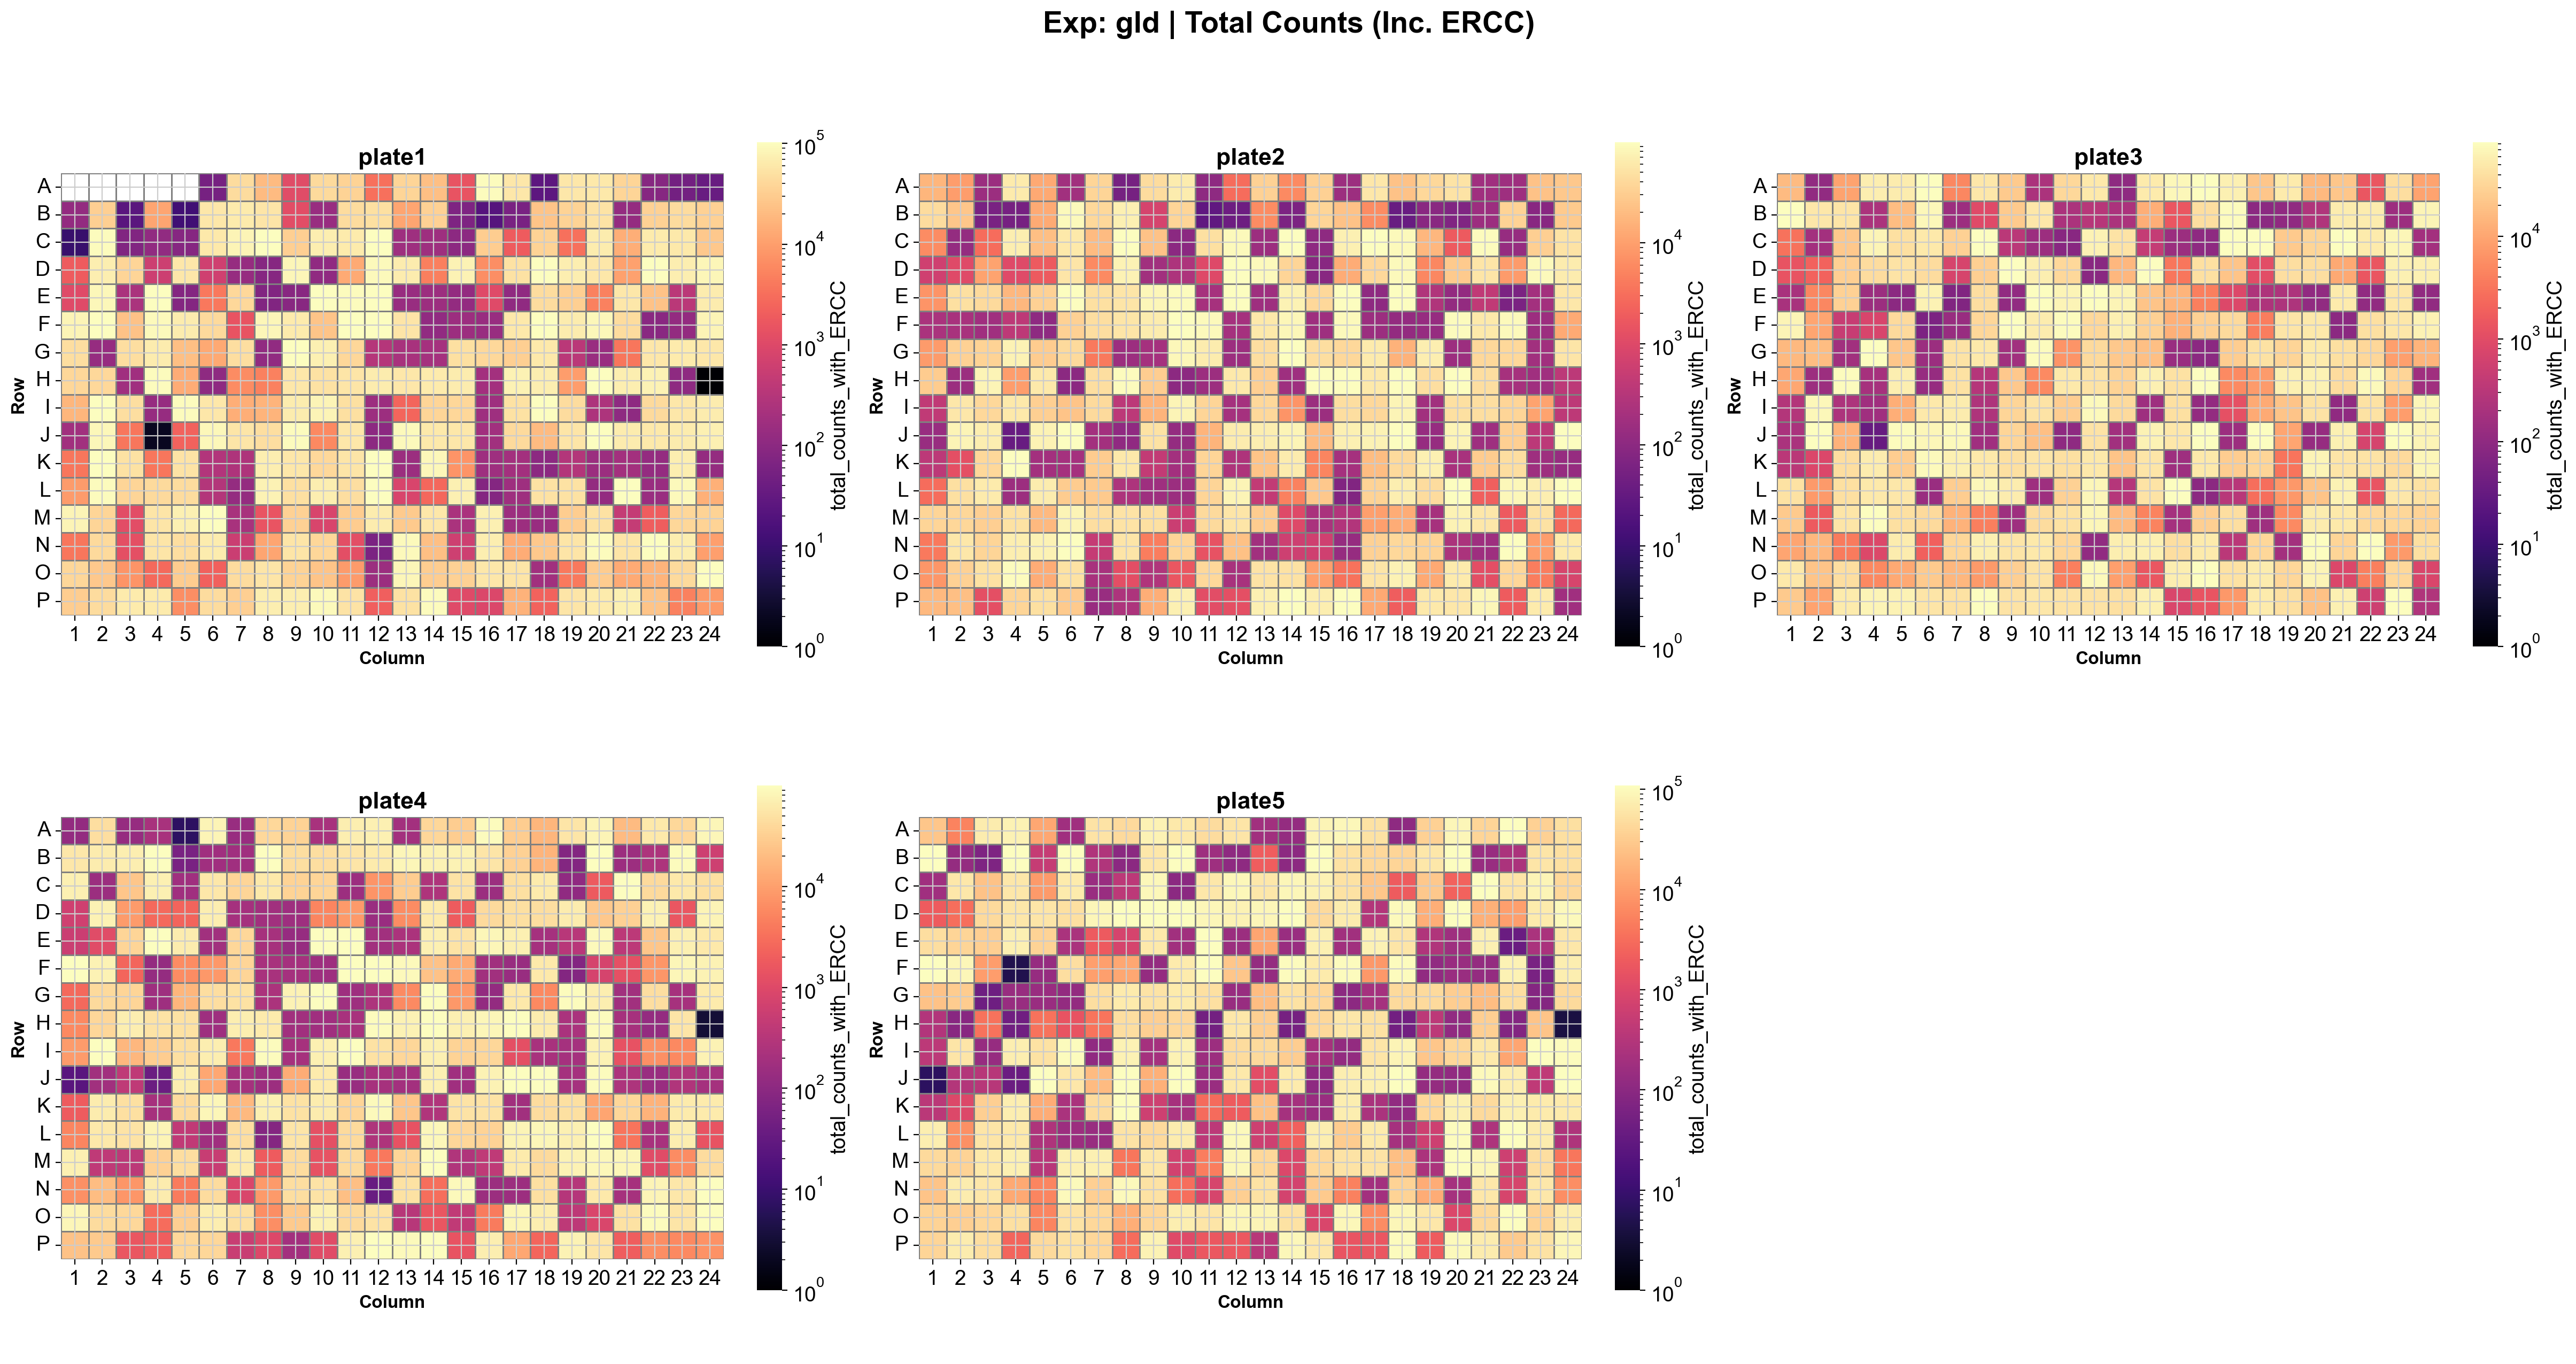

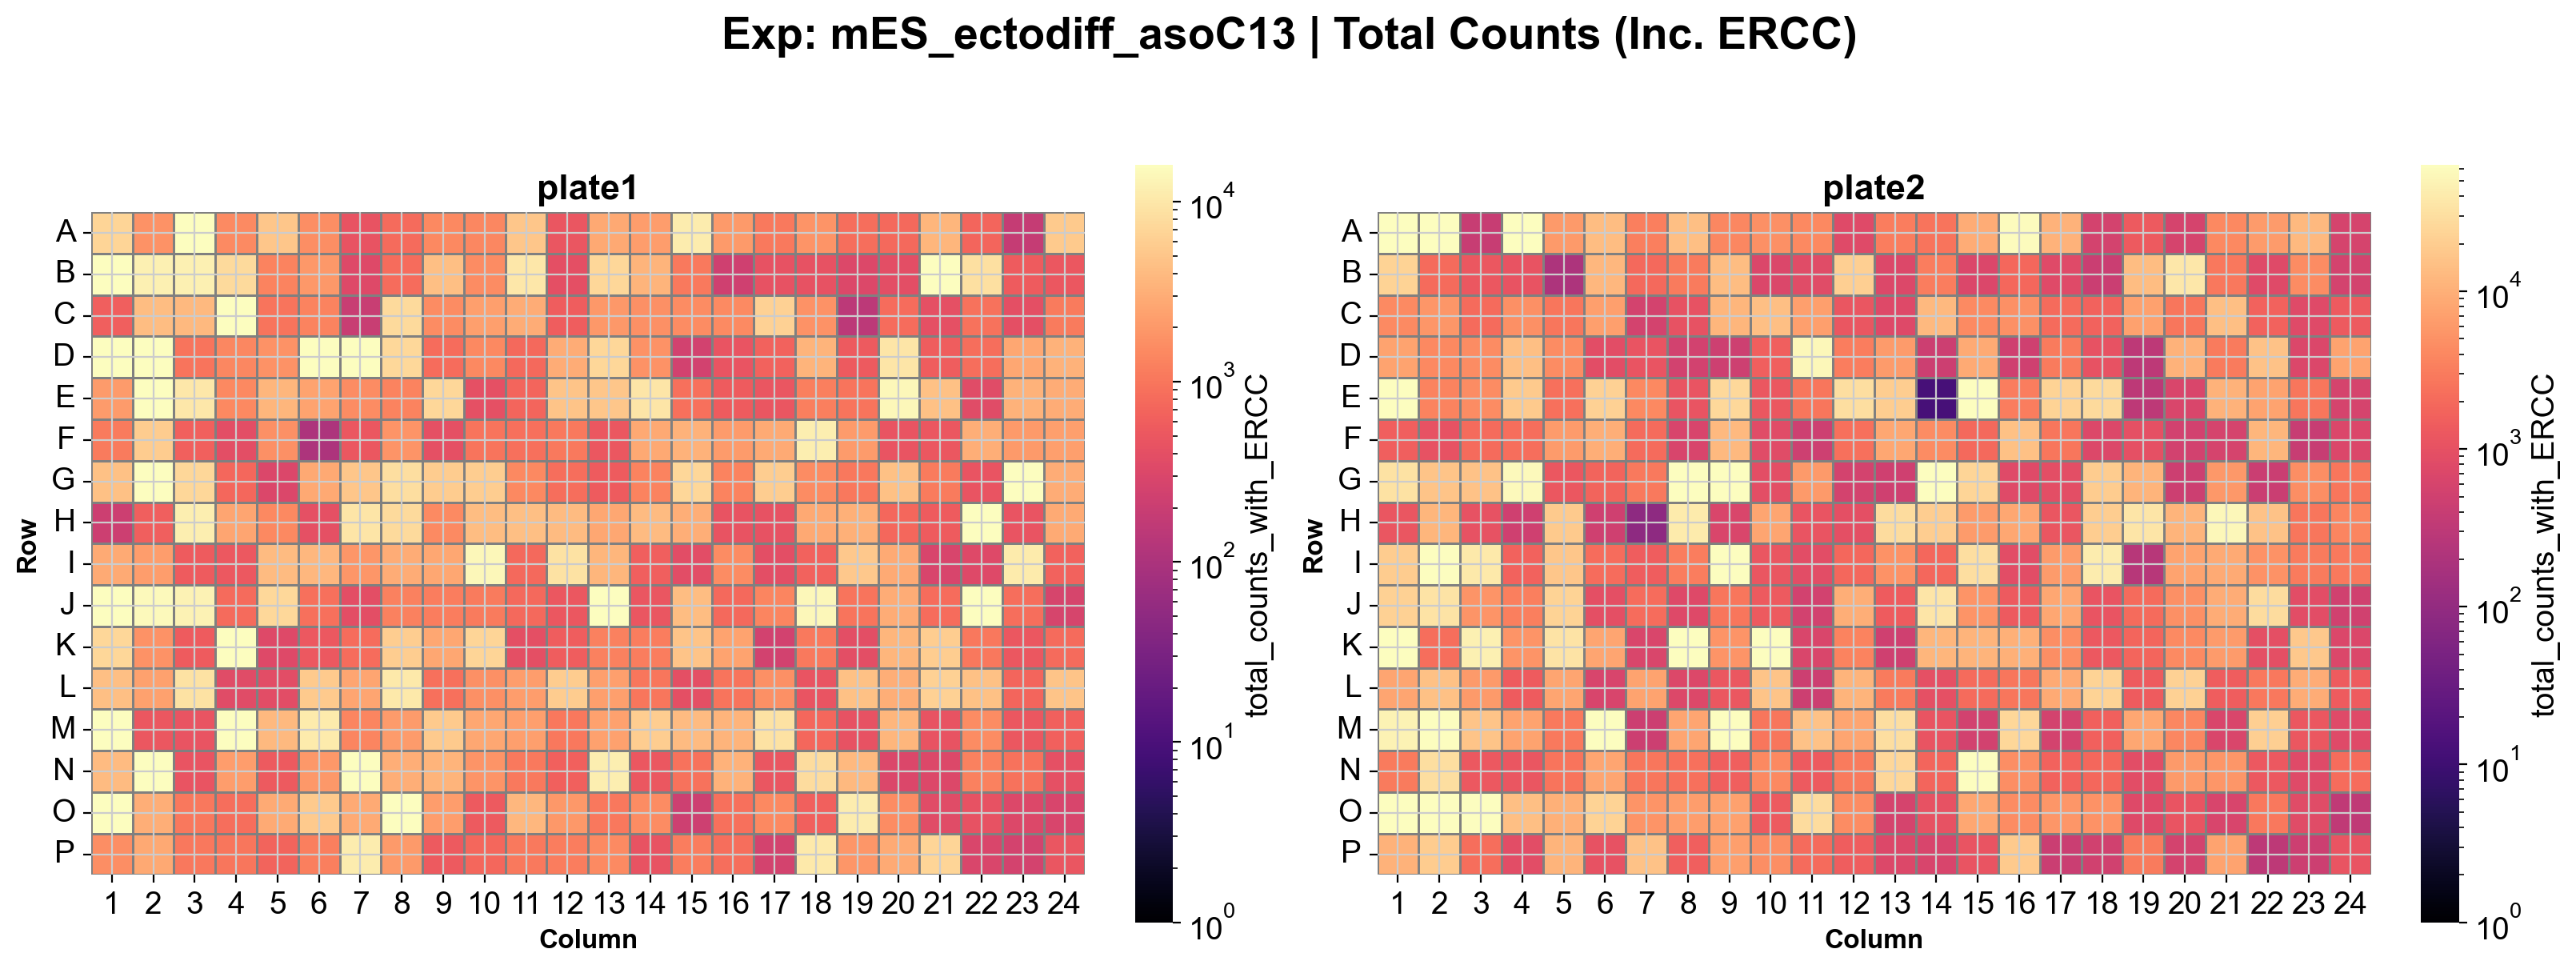

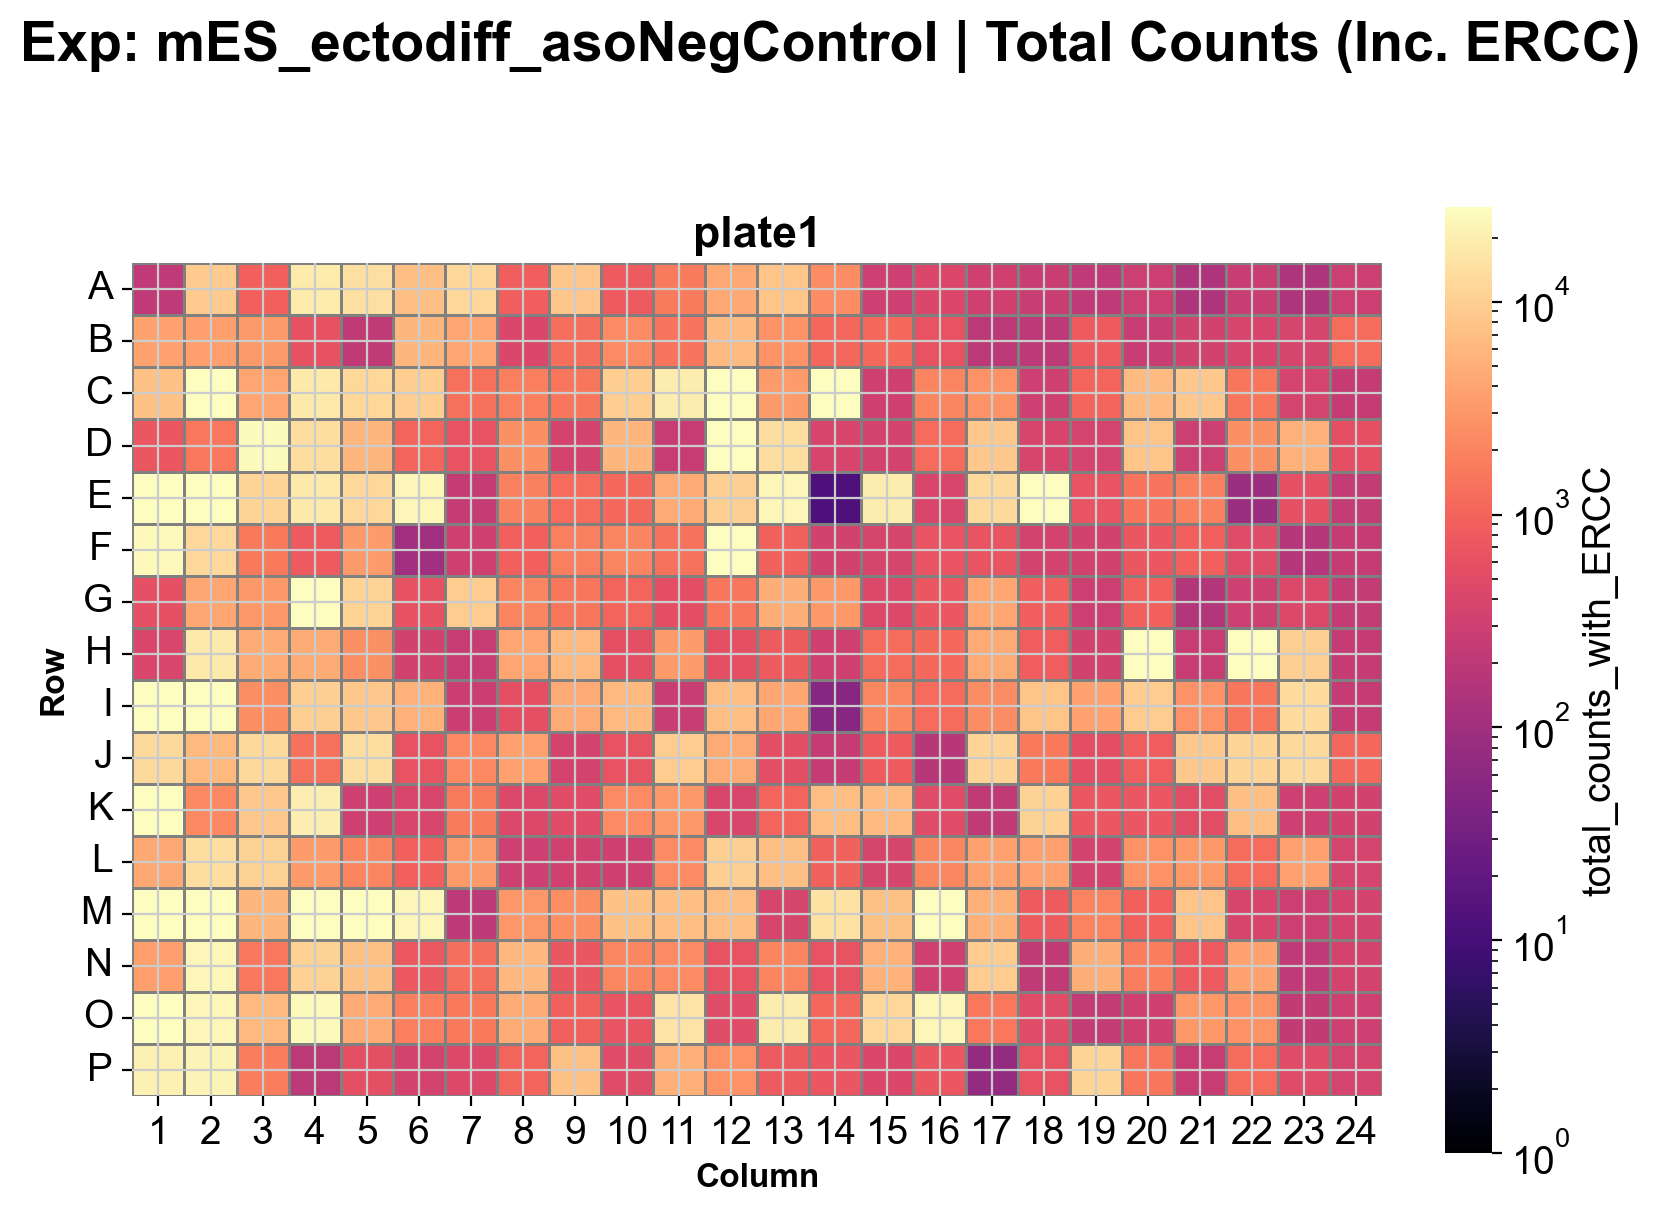

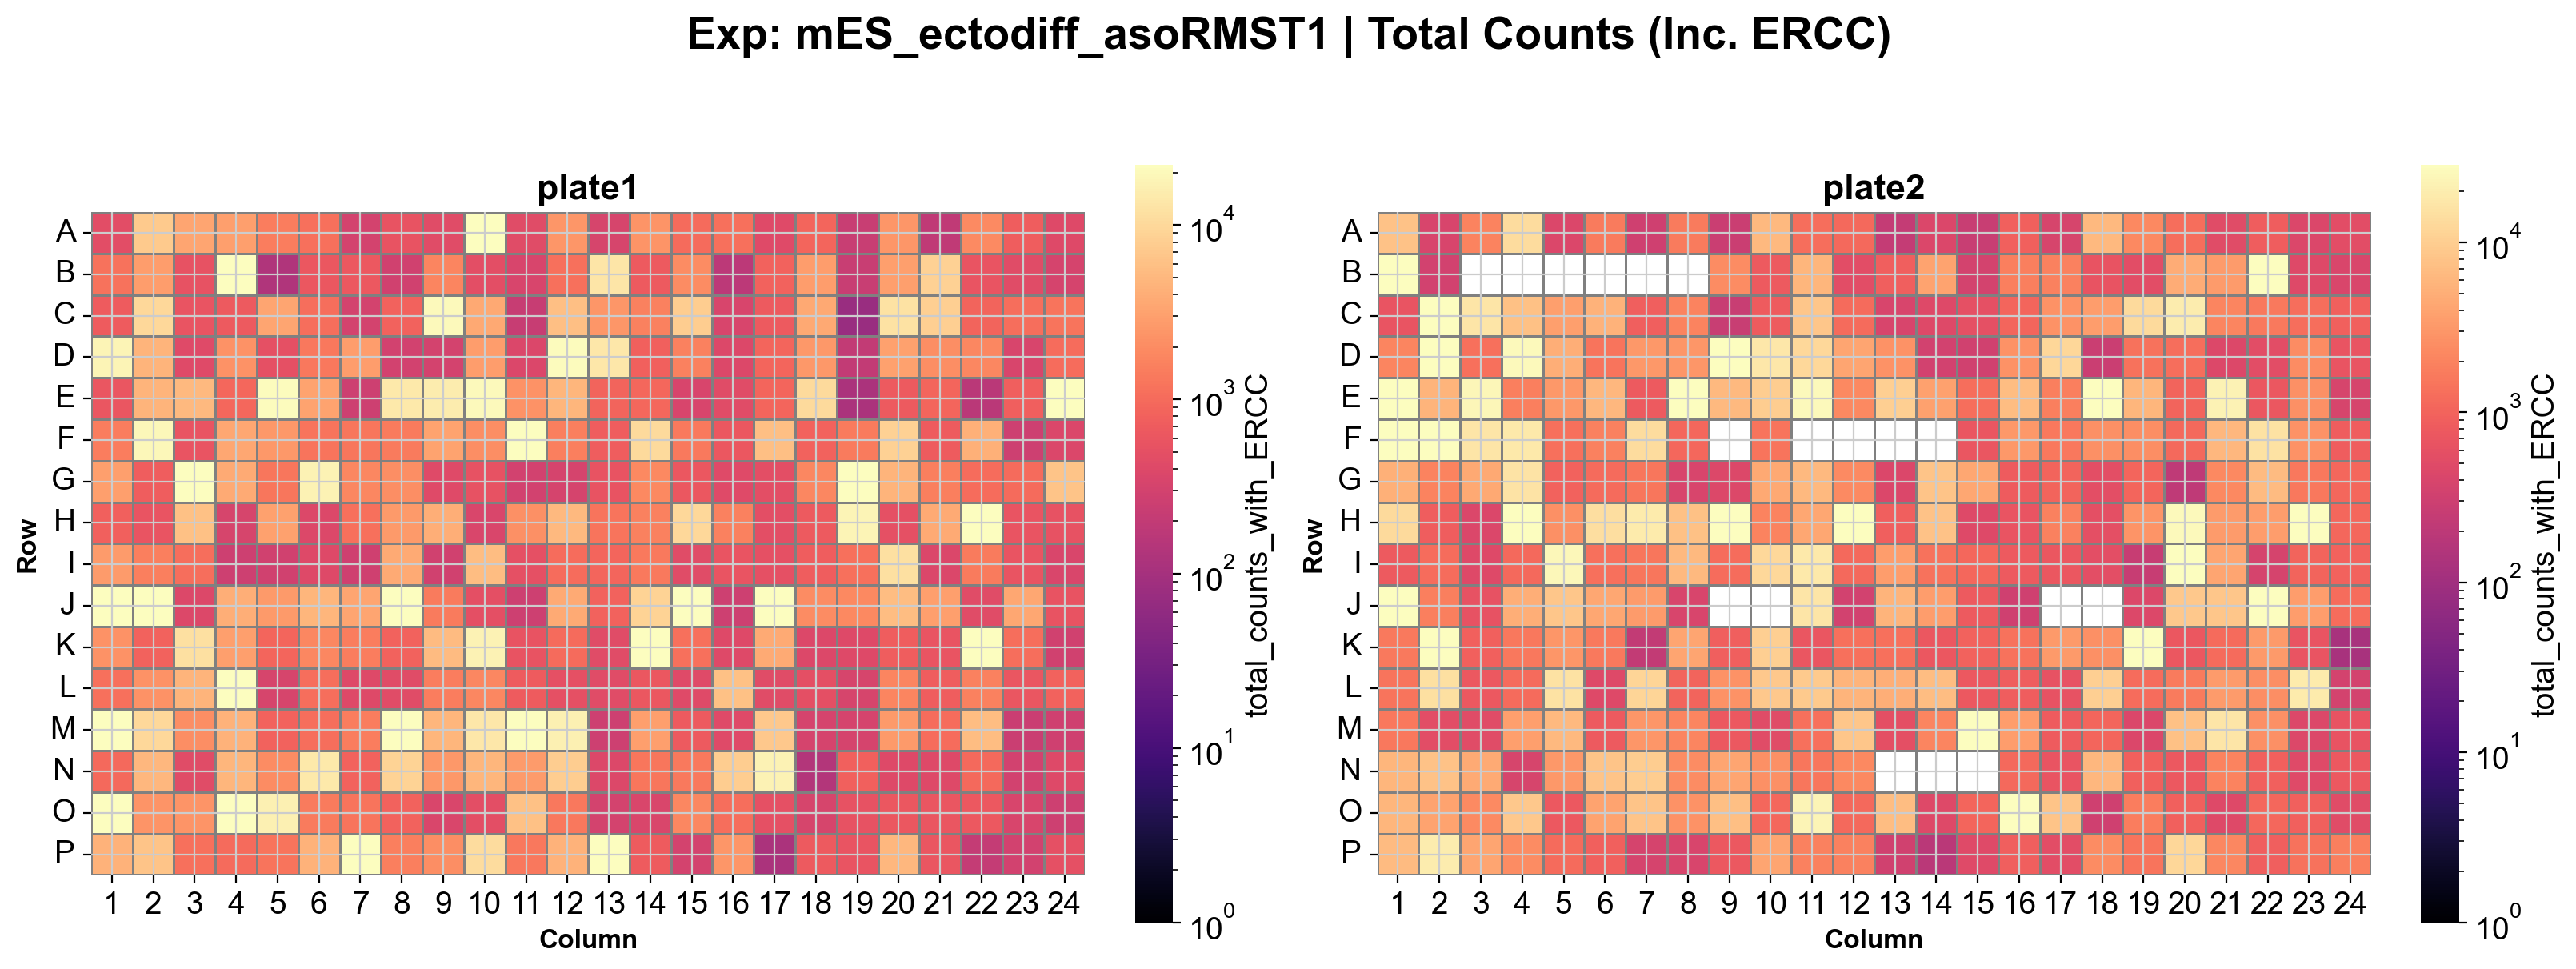

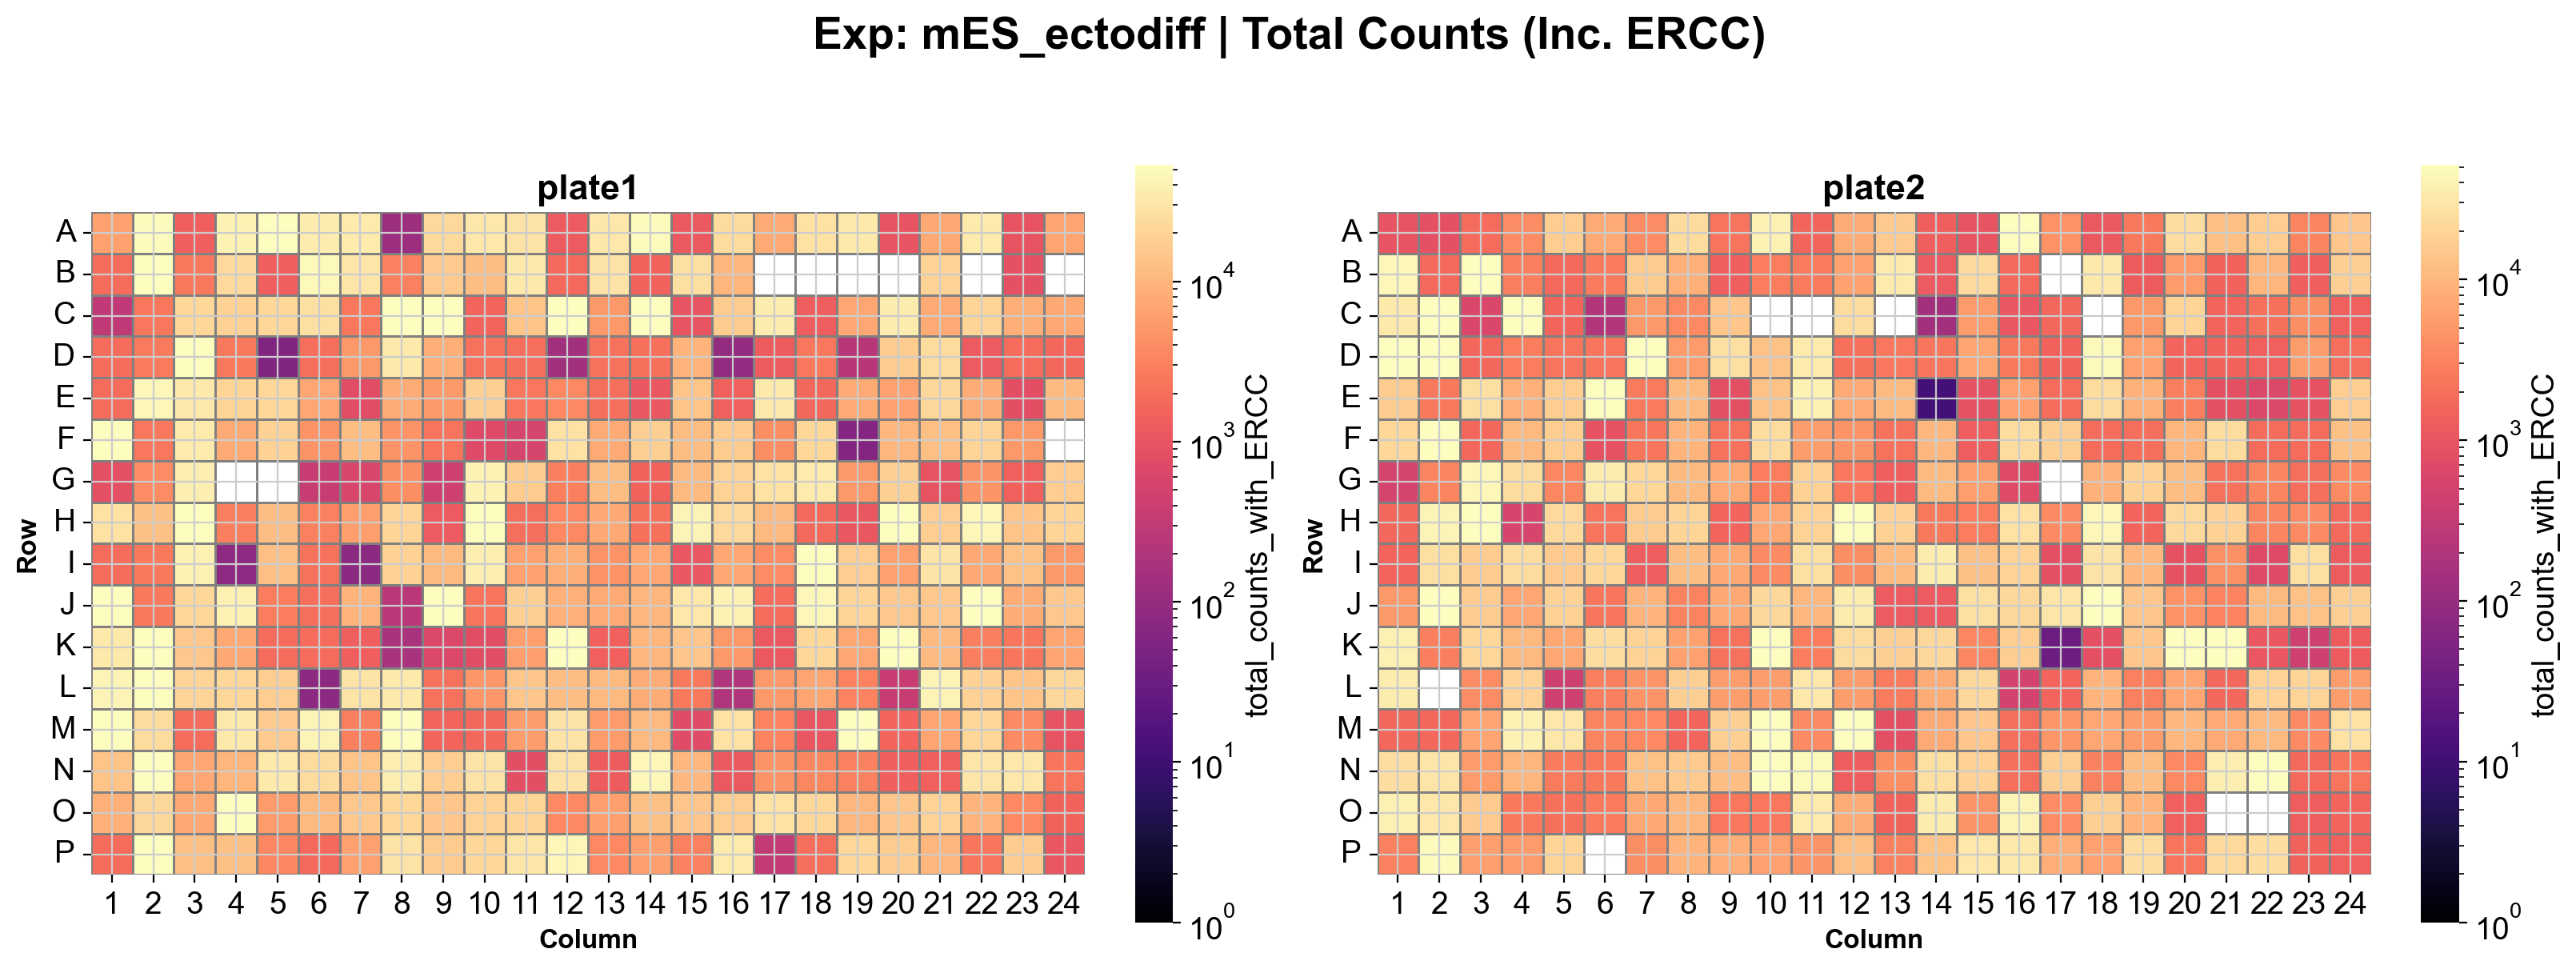

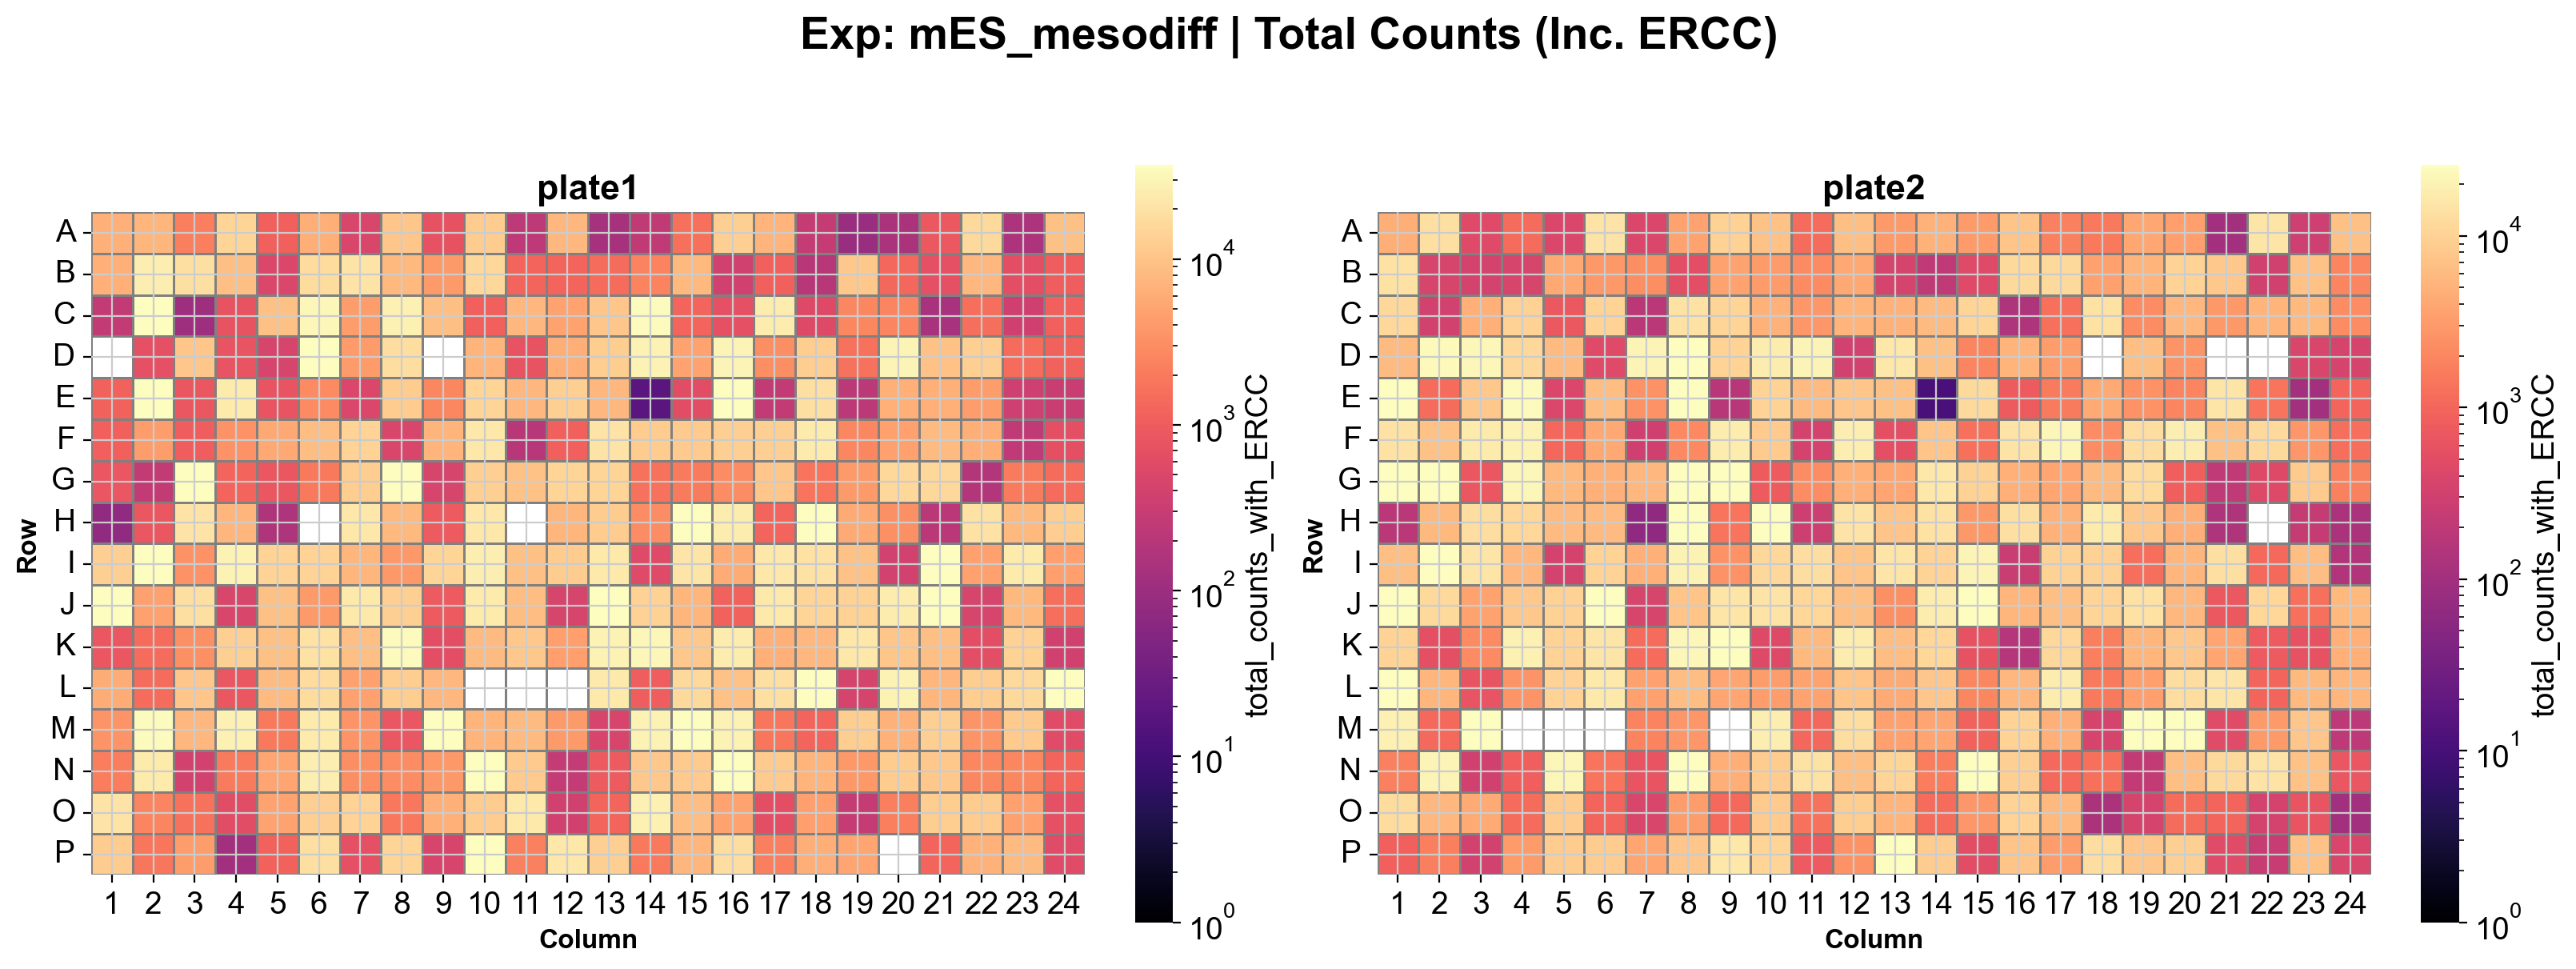

In [ ]:
# --- DEFINE PLOTTING FUNCTION (PHYSICS TOPOLOGY MAP) ---
# Encapsulating your plot logic to reuse it easily.
def plot_plate_heatmap(adata_obj, metric_col, title_suffix=""):
    
    # Rows mapping (A-P)
    rows_letters = list("ABCDEFGHIJKLMNOP")
    row_map = {letter: i for i, letter in enumerate(rows_letters)}
    cols_numbers = list(range(1, 25))

    # Coord mapper
    def well_to_coord(well_id):
        try:
            r = well_id[0] # Letter
            c = int(well_id[1:]) # Number
            return row_map[r], c - 1 # 0-based index
        except (KeyError, ValueError, IndexError, TypeError):
            return None, None

    # Iteration over experiments
    experiments = adata_obj.obs['experiment'].unique()

    for exp in experiments:
        subset = adata_obj.obs[adata_obj.obs['experiment'] == exp]
        plates = sorted(subset['plate'].unique())
        n_plates = len(plates)
        
        # Grid layout calculation
        n_cols = min(n_plates, 3)
        n_rows = math.ceil(n_plates / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows), constrained_layout=True)
        
        # Main Title
        fig.suptitle(f"Exp: {exp} | {title_suffix}", 
                     fontsize=20, fontweight='bold', y=1.05)
        
        if n_plates > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        for i, plate in enumerate(plates):
            ax = axes[i]
            plate_data = subset[subset['plate'] == plate]
            
            # Initialize empty matrix (NaN for visualization)
            matrix = np.full((16, 24), np.nan)
            
            for _, row in plate_data.iterrows():
                # Ensure we use the correct column for well ID
                # Adjust 'well_ID' or 'well_id' based on your previous steps
                r_idx, c_idx = well_to_coord(row.get('well_ID', row.get('well_id'))) 
                
                if r_idx is not None and 0 <= c_idx < 24:
                    # +1 to avoid log(0)
                    matrix[r_idx, c_idx] = row[metric_col] + 1
            
            # Contrast Strategy
            # 95th percentile to handle outliers
            vmax_val = np.nanpercentile(matrix, 95)
            vmin_val = 1 # Floor for LogNorm
            
            # Plot Heatmap
            sns.heatmap(
                matrix, 
                ax=ax, 
                cmap="magma", 
                norm=LogNorm(vmin=vmin_val, vmax=vmax_val), 
                cbar_kws={'label': metric_col, 'shrink': 0.8},
                xticklabels=cols_numbers,
                yticklabels=rows_letters,
                square=True,
                linewidths=0.5, linecolor='gray'
            )
            
            ax.set_title(f"{plate}", fontsize=16, fontweight='bold')
            ax.set_xlabel("Column", fontsize=12, fontweight='bold')
            ax.set_ylabel("Row", fontsize=12, fontweight='bold')
            ax.tick_params(axis='x', rotation=0)
            ax.tick_params(axis='y', rotation=0)

        # Turn off unused axes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.show()

# --- PLOT RAW DATA (Including ERCC) ---
print("Generating Heatmaps for RAW data (Endogenous + ERCC)...")
plot_plate_heatmap(adata, 'total_counts_with_ERCC', title_suffix="Total Counts (Inc. ERCC)")

## QC METRICS (WITHOUT ERCC)

Discarding ERCC RNA counts.

In [ ]:
# --- DEFINE ERCC GENES ---
# Ensure we capture them correctly (case sensitive check)
# Some datasets use "ERCC-", others "Ercc-"
ercc_mask = adata.var_names.str.startswith('ERCC-')
n_ercc = ercc_mask.sum()
print(f"Detected {n_ercc} ERCC spike-in genes.")

if n_ercc == 0:
    print("WARNING: No ERCC genes found with prefix 'ERCC-'. Check gene names.")
else:
    # --- STATISTICS BEFORE REMOVAL ---
    # We look specifically at Empty wells (if they exist) and mESC
    if 'Empty' in adata.obs['sample_type'].values:
        empty_subset = adata[adata.obs['sample_type'] == 'Empty']
        mean_before = empty_subset.obs['total_counts'].mean()
        median_before = empty_subset.obs['total_counts'].median()
        
        # Calculate what % of the Empty well signal is ERCC
        # We need to manually sum ERCC counts for this check
        ercc_counts = np.sum(empty_subset[:, ercc_mask].X, axis=1)
        mean_ercc_counts = np.mean(ercc_counts)
        
        print(f"\n--- PRE-FILTERING DIAGNOSTICS (EMPTY WELLS) ---")
        print(f"Mean Total Counts: {mean_before:.2f}")
        print(f"Mean ERCC Counts:  {mean_ercc_counts:.2f}")
        print(f"ERCC Contribution: {(mean_ercc_counts/mean_before)*100:.2f}%")
    
    # --- FILTERING ---
    print("\n... Removing ERCC genes ...")
    # Invert mask to keep non-ERCC
    adata = adata[:, ~ercc_mask].copy()
    
    # --- RECALCULATE QC METRICS ---
    # This updates 'total_counts' to reflect ONLY endogenous RNA
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt'], # ERCC is gone
        percent_top=None, 
        log1p=False, 
        inplace=True
    )
    
    # --- STATISTICS AFTER REMOVAL ---
    if 'Empty' in adata.obs['sample_type'].values:
        empty_subset_after = adata[adata.obs['sample_type'] == 'Empty']
        mean_after = empty_subset_after.obs['total_counts'].mean()
        
        print(f"\n--- POST-FILTERING DIAGNOSTICS (EMPTY WELLS) ---")
        print(f"Mean Total Counts (Endogenous Only): {mean_after:.2f}")
        
        # --- PHYSICS CHECK ---
        delta = mean_before - mean_after
        print(f"\n--- CONCLUSION ---")
        print(f"Signal Removed (Calibration): {delta:.2f}")
        print(f"Residual Noise (Ambient RNA): {mean_after:.2f}")
        
        if mean_after < mean_before * 0.1:
            print(">> SUCCESS: Empty wells were mostly ERCC. Residual noise is low.")
        elif mean_after > mean_before * 0.9:
            print(">> WARNING: Filtering ERCC had little effect. Empty wells contain mostly Ambient RNA (or no ERCC were added).")

Detected 92 ERCC spike-in genes.

--- PRE-FILTERING DIAGNOSTICS (EMPTY WELLS) ---
Mean Total Counts: 14960.36
Mean ERCC Counts:  365.98
ERCC Contribution: 2.45%

... Removing ERCC genes ...

--- POST-FILTERING DIAGNOSTICS (EMPTY WELLS) ---
Mean Total Counts (Endogenous Only): 14594.37

--- CONCLUSION ---
Signal Removed (Calibration): 365.98
Residual Noise (Ambient RNA): 14594.37
>> WARNING: Filtering ERCC had little effect. Empty wells contain mostly Ambient RNA (or no ERCC were added).


## HEATMAPS (WITHOUT ERCC)

Now we observe the empty wells in the experiment.

Generating Heatmaps for CLEAN data (Endogenous RNA only)...


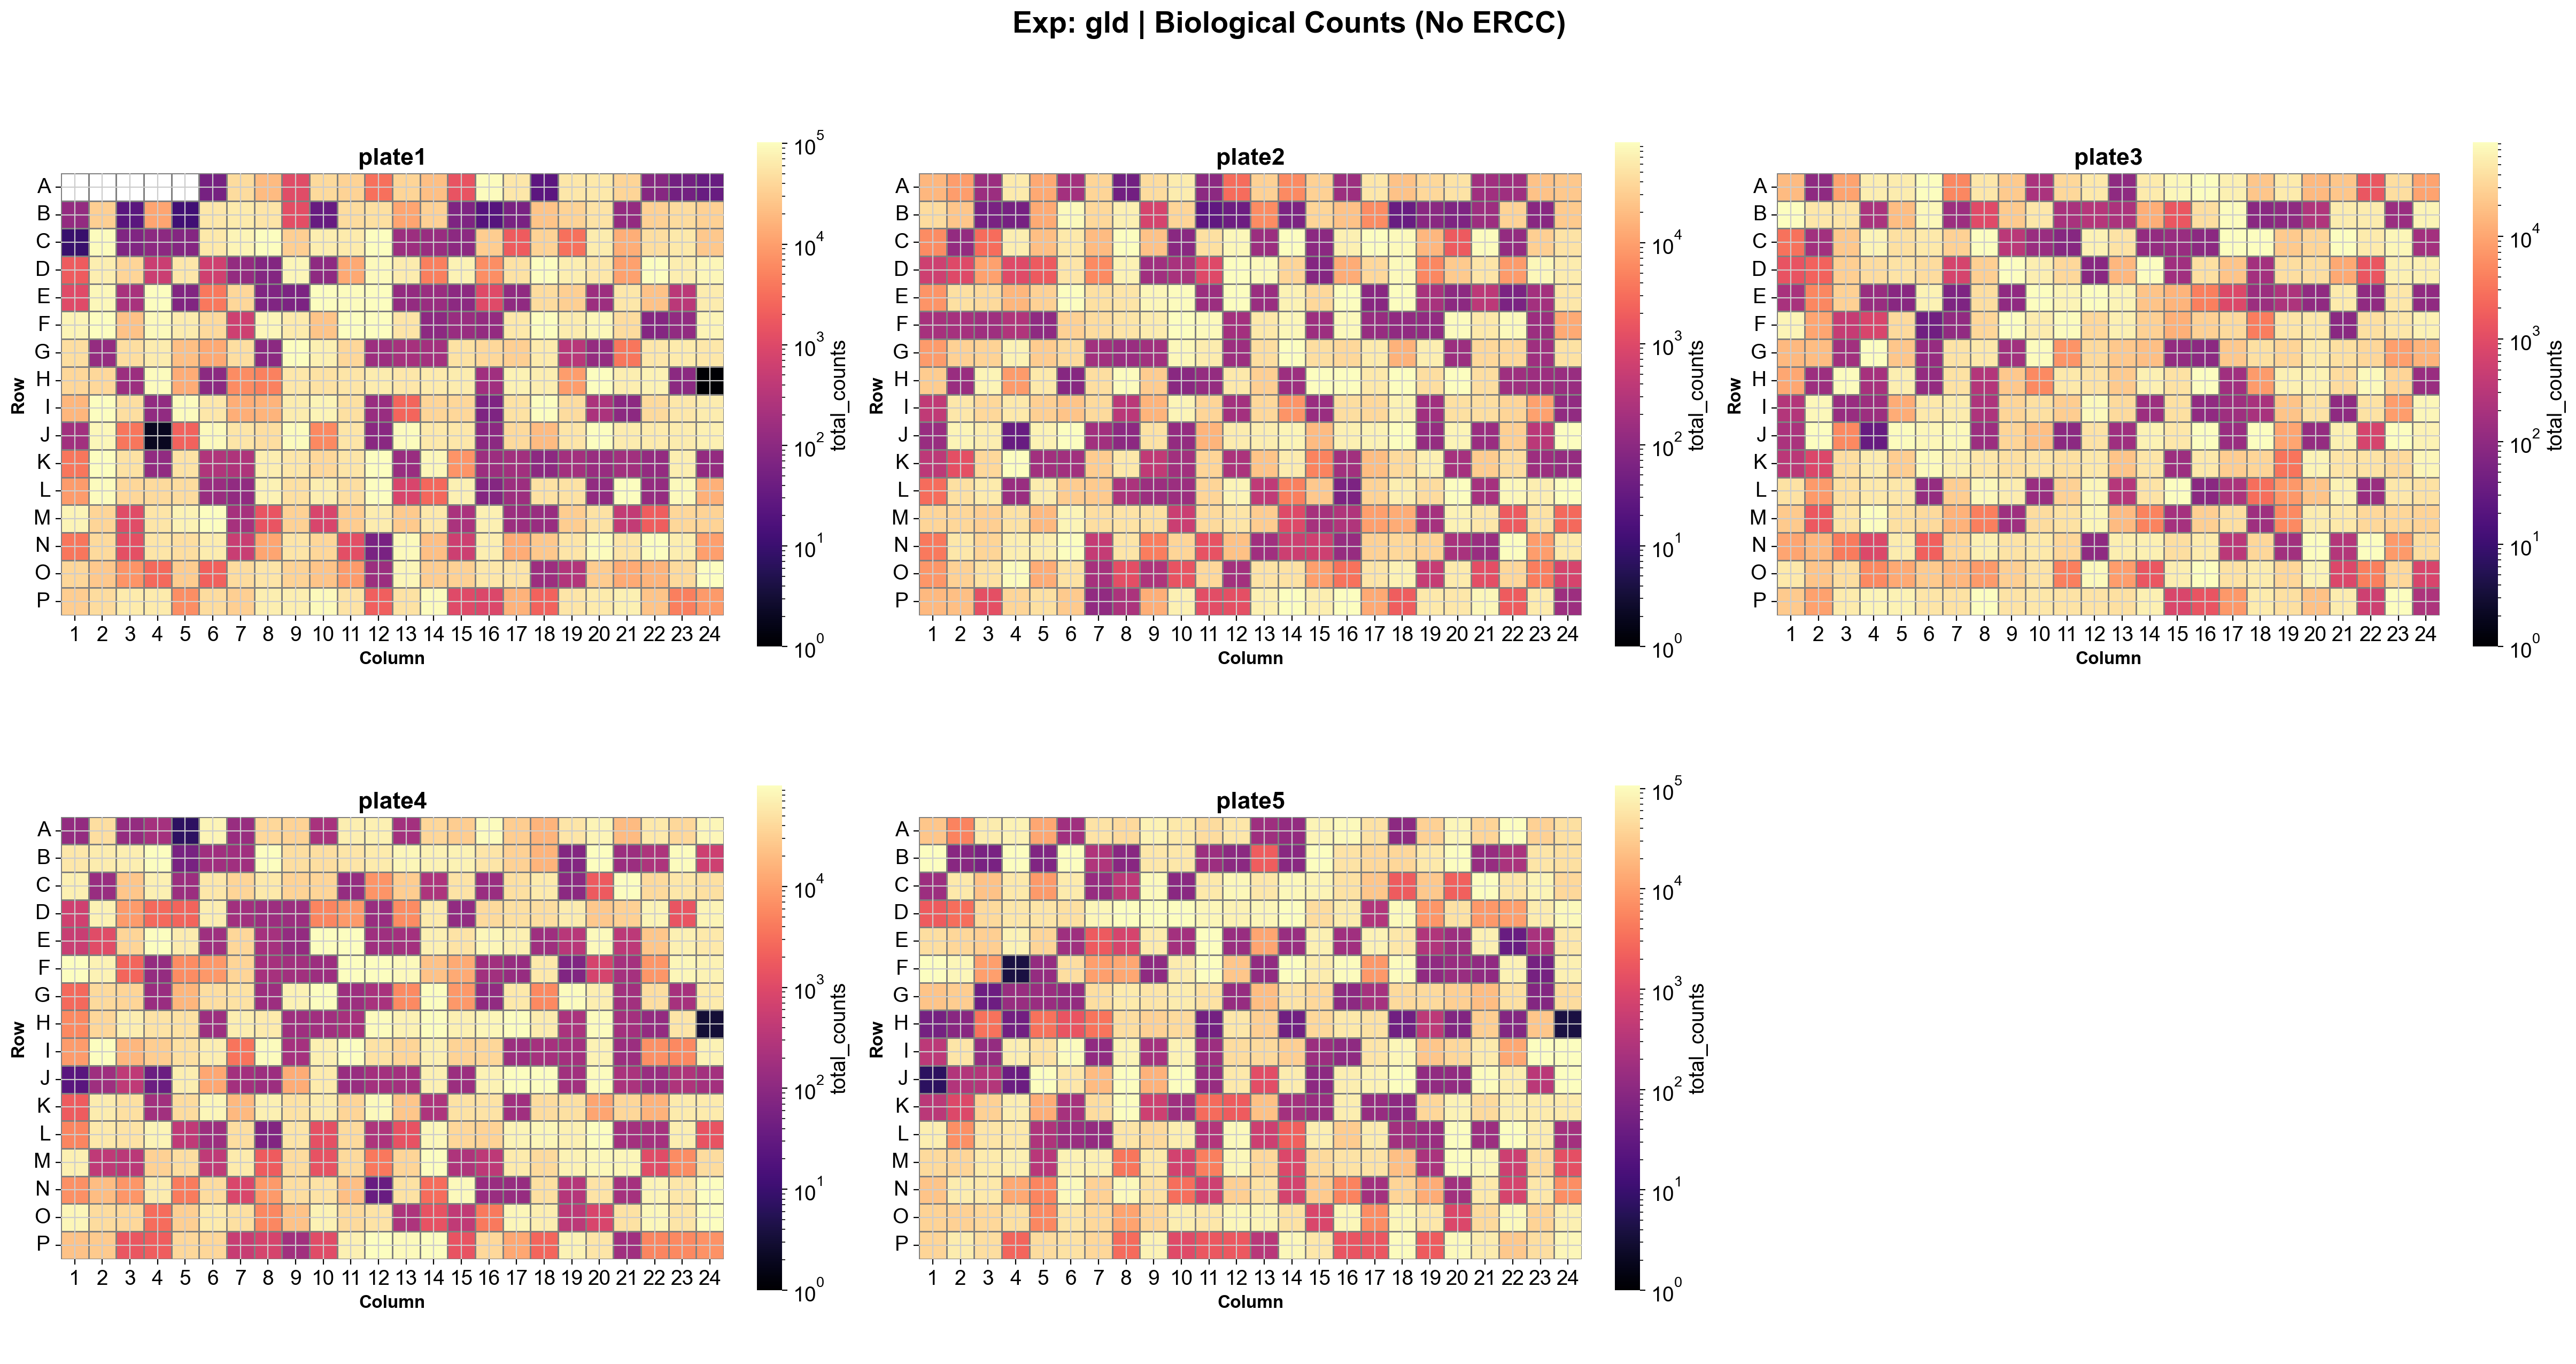

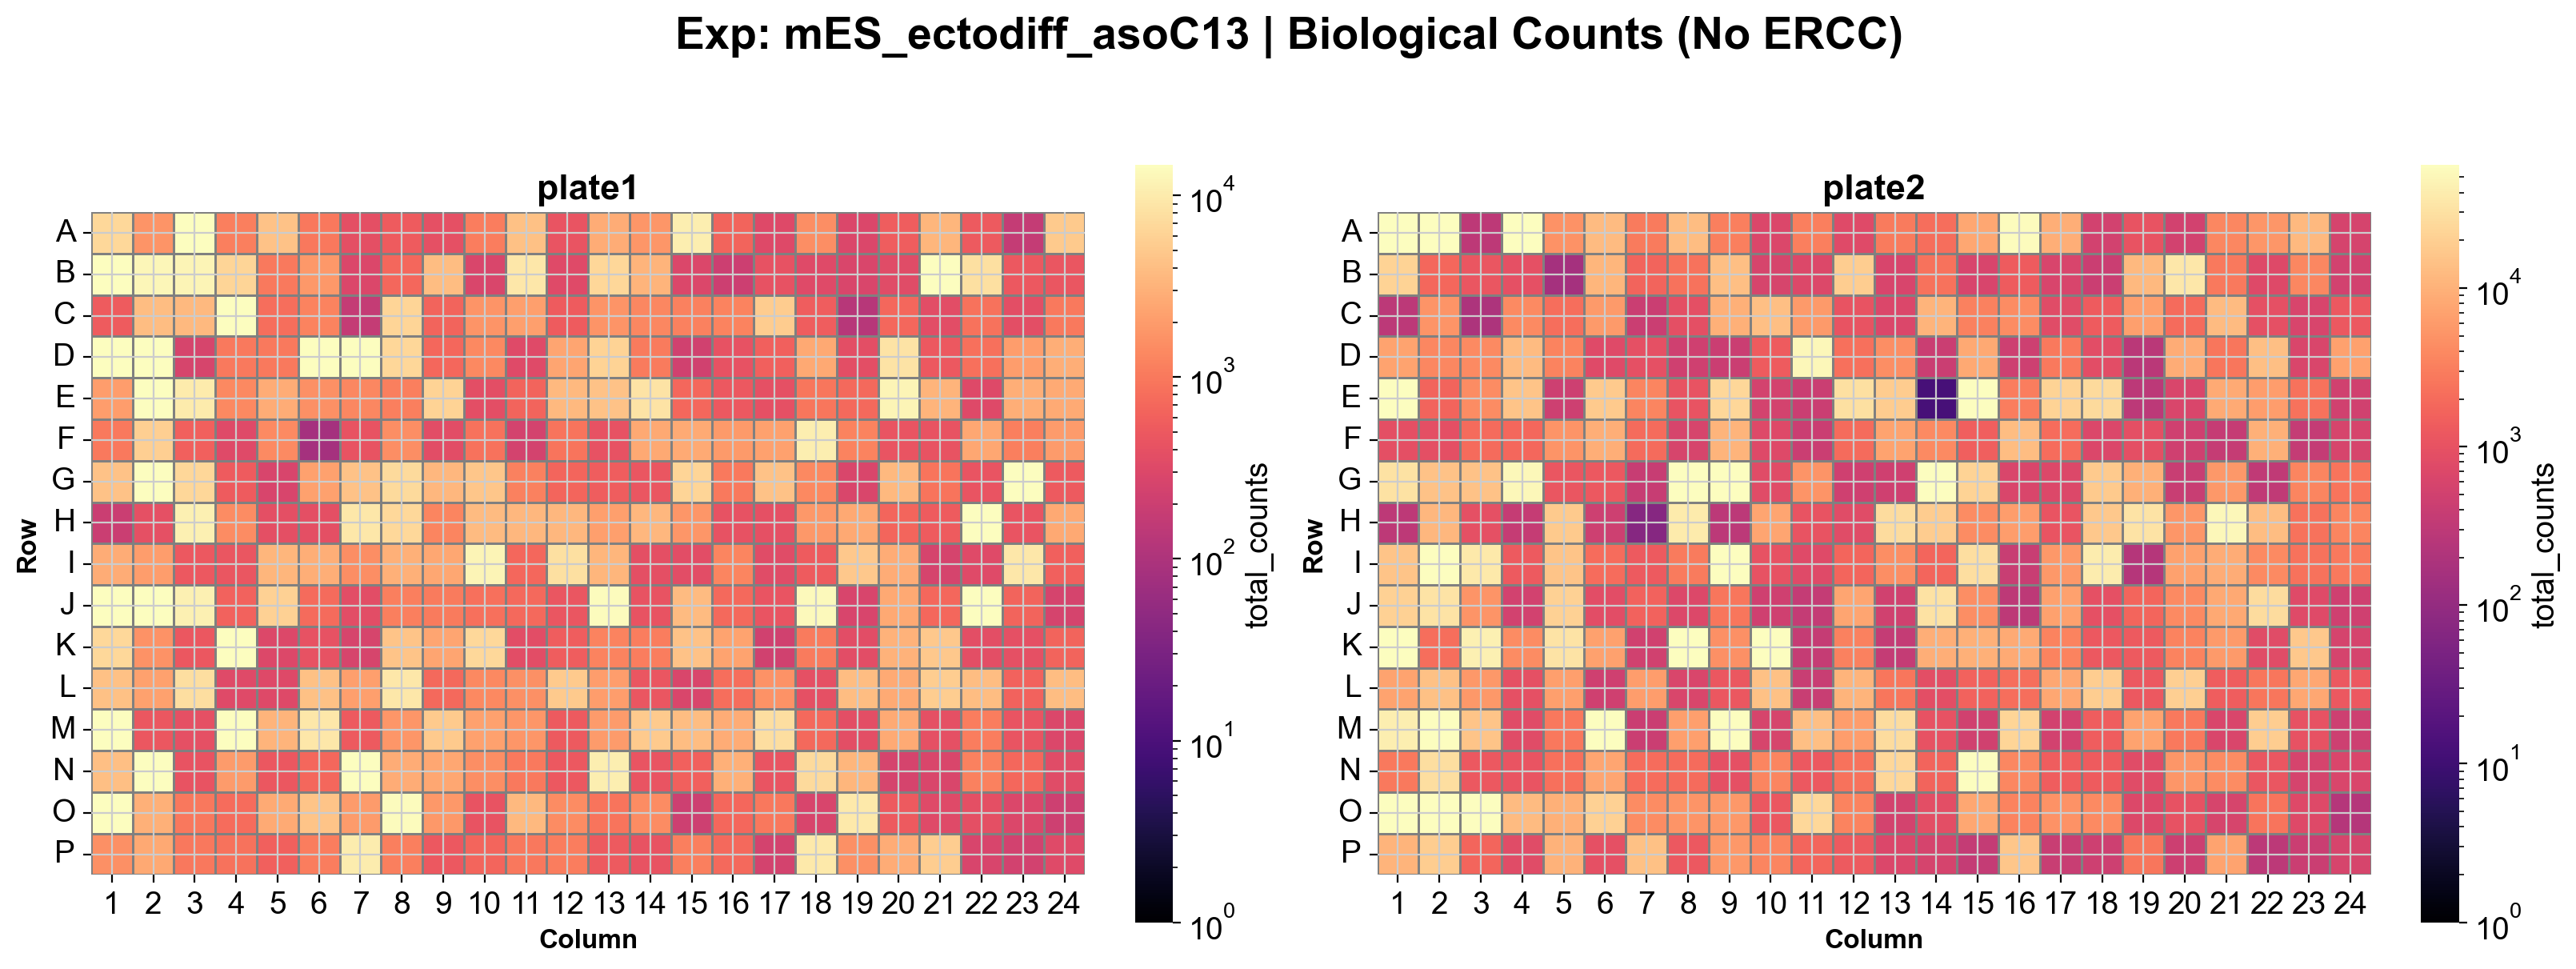

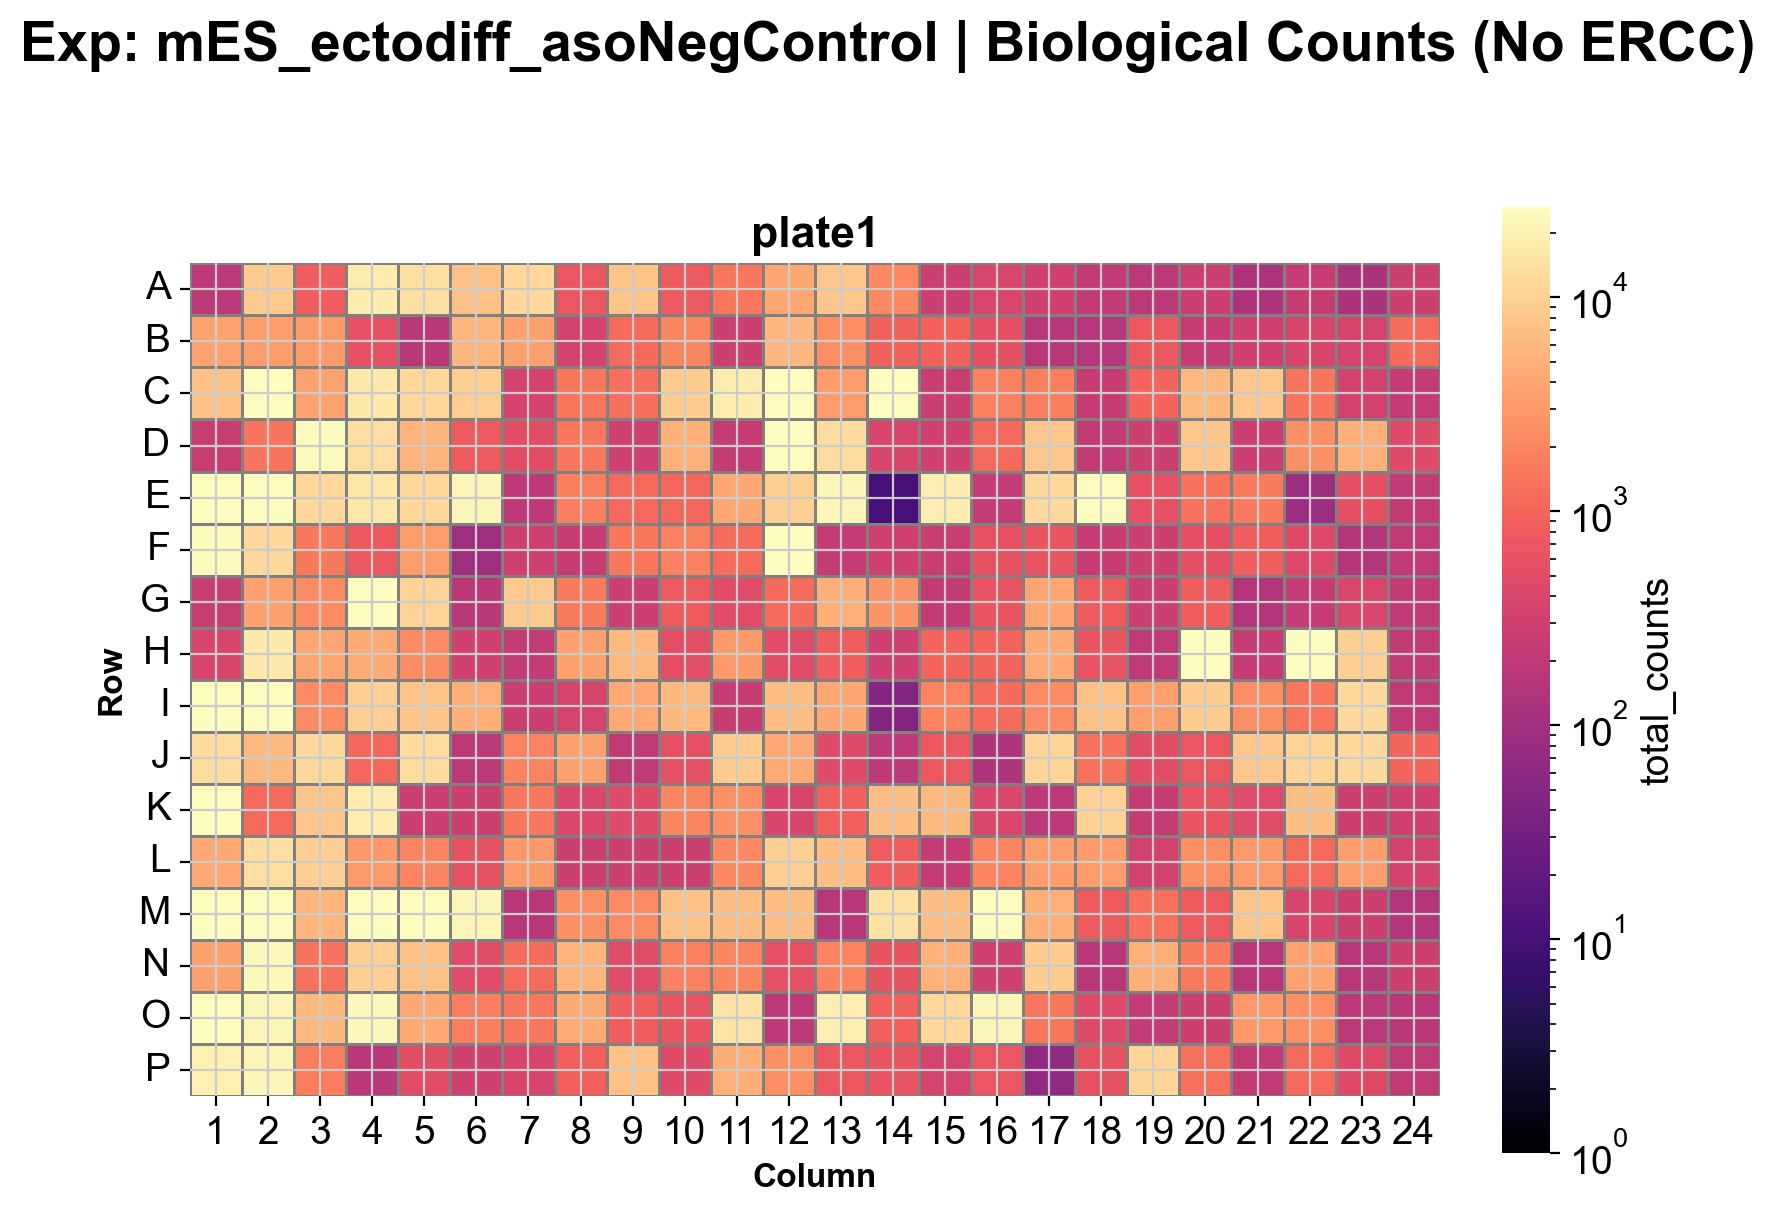

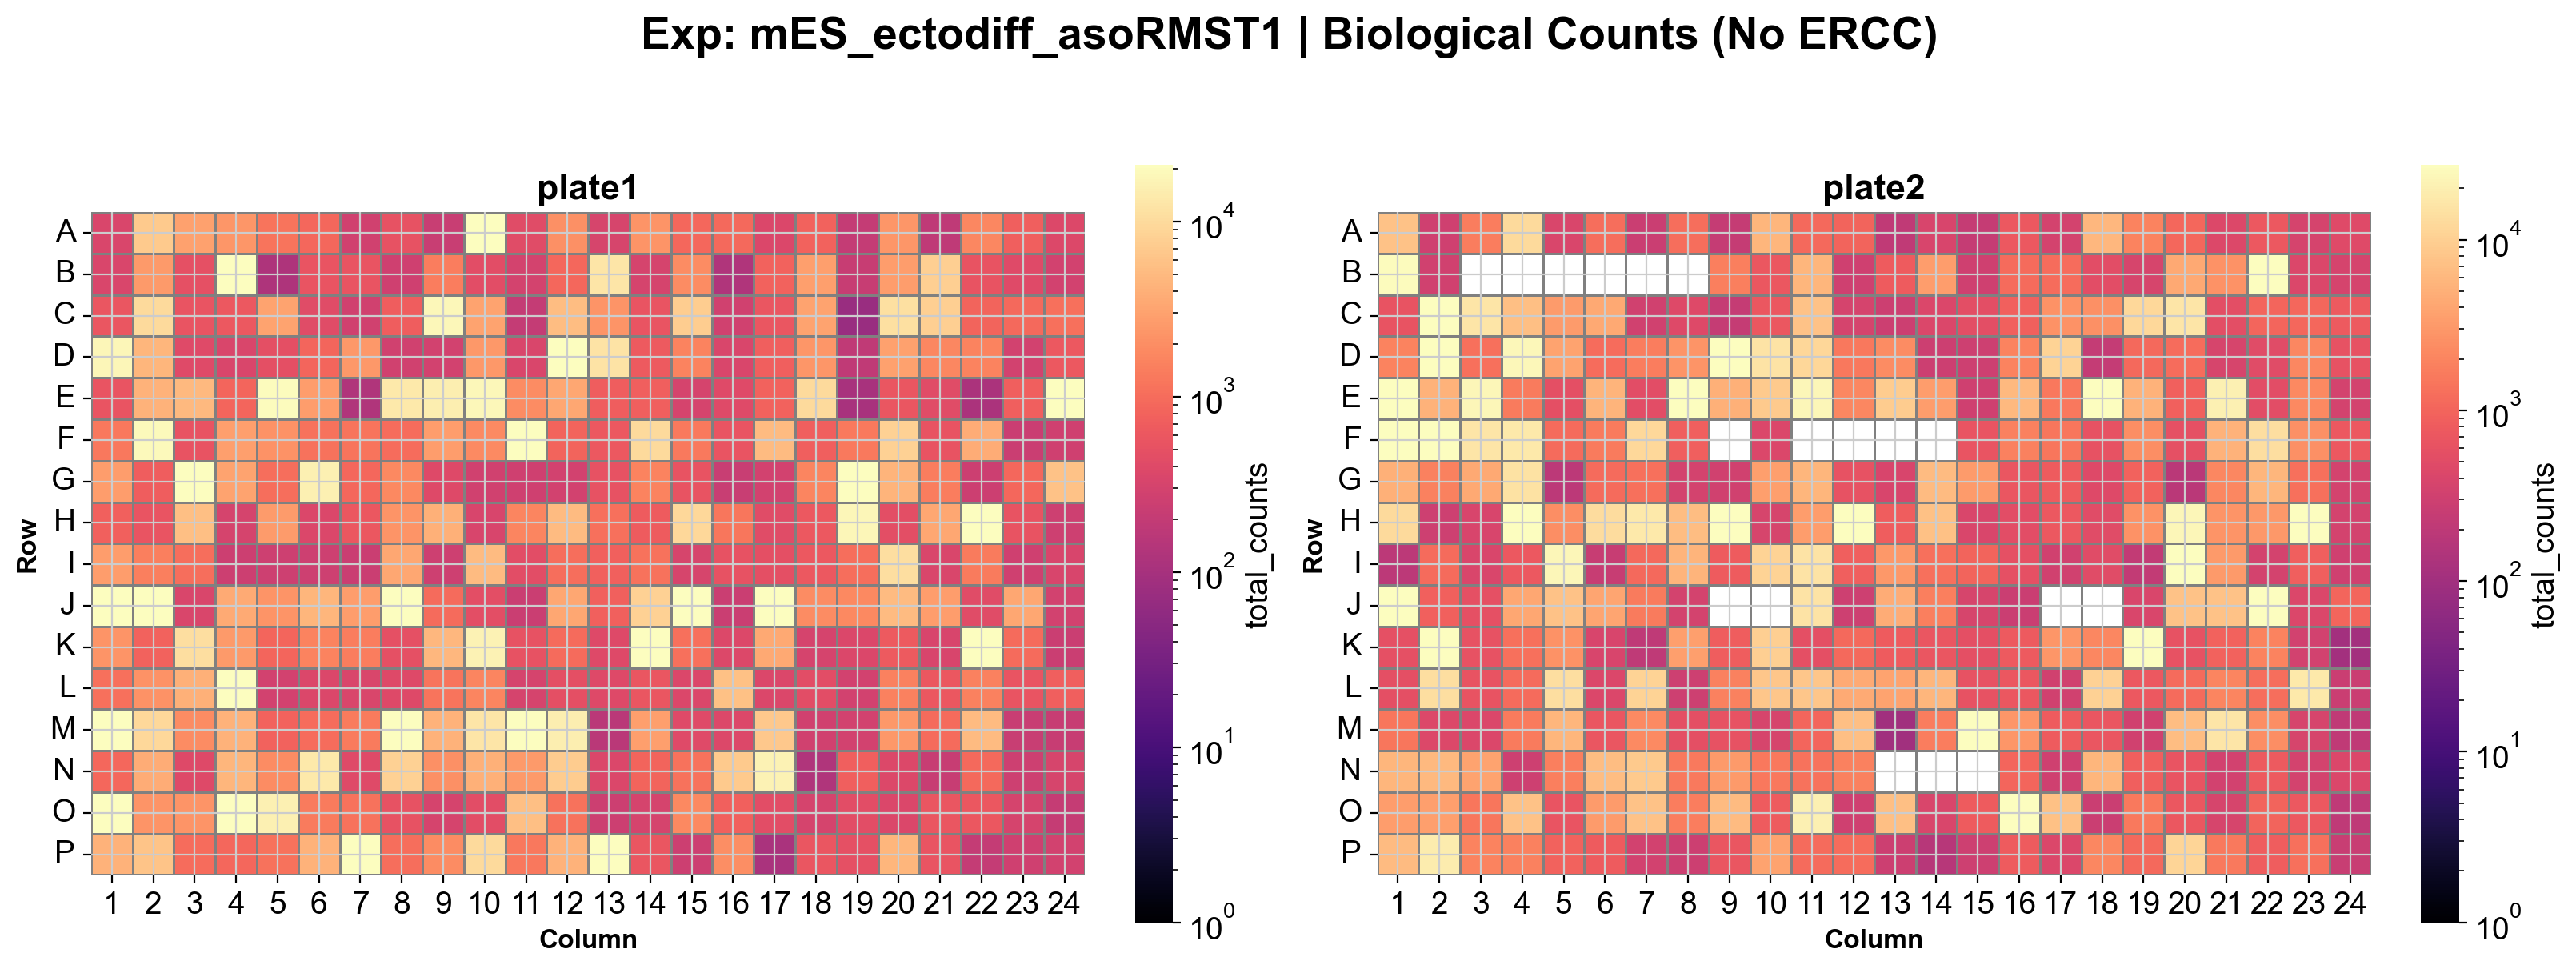

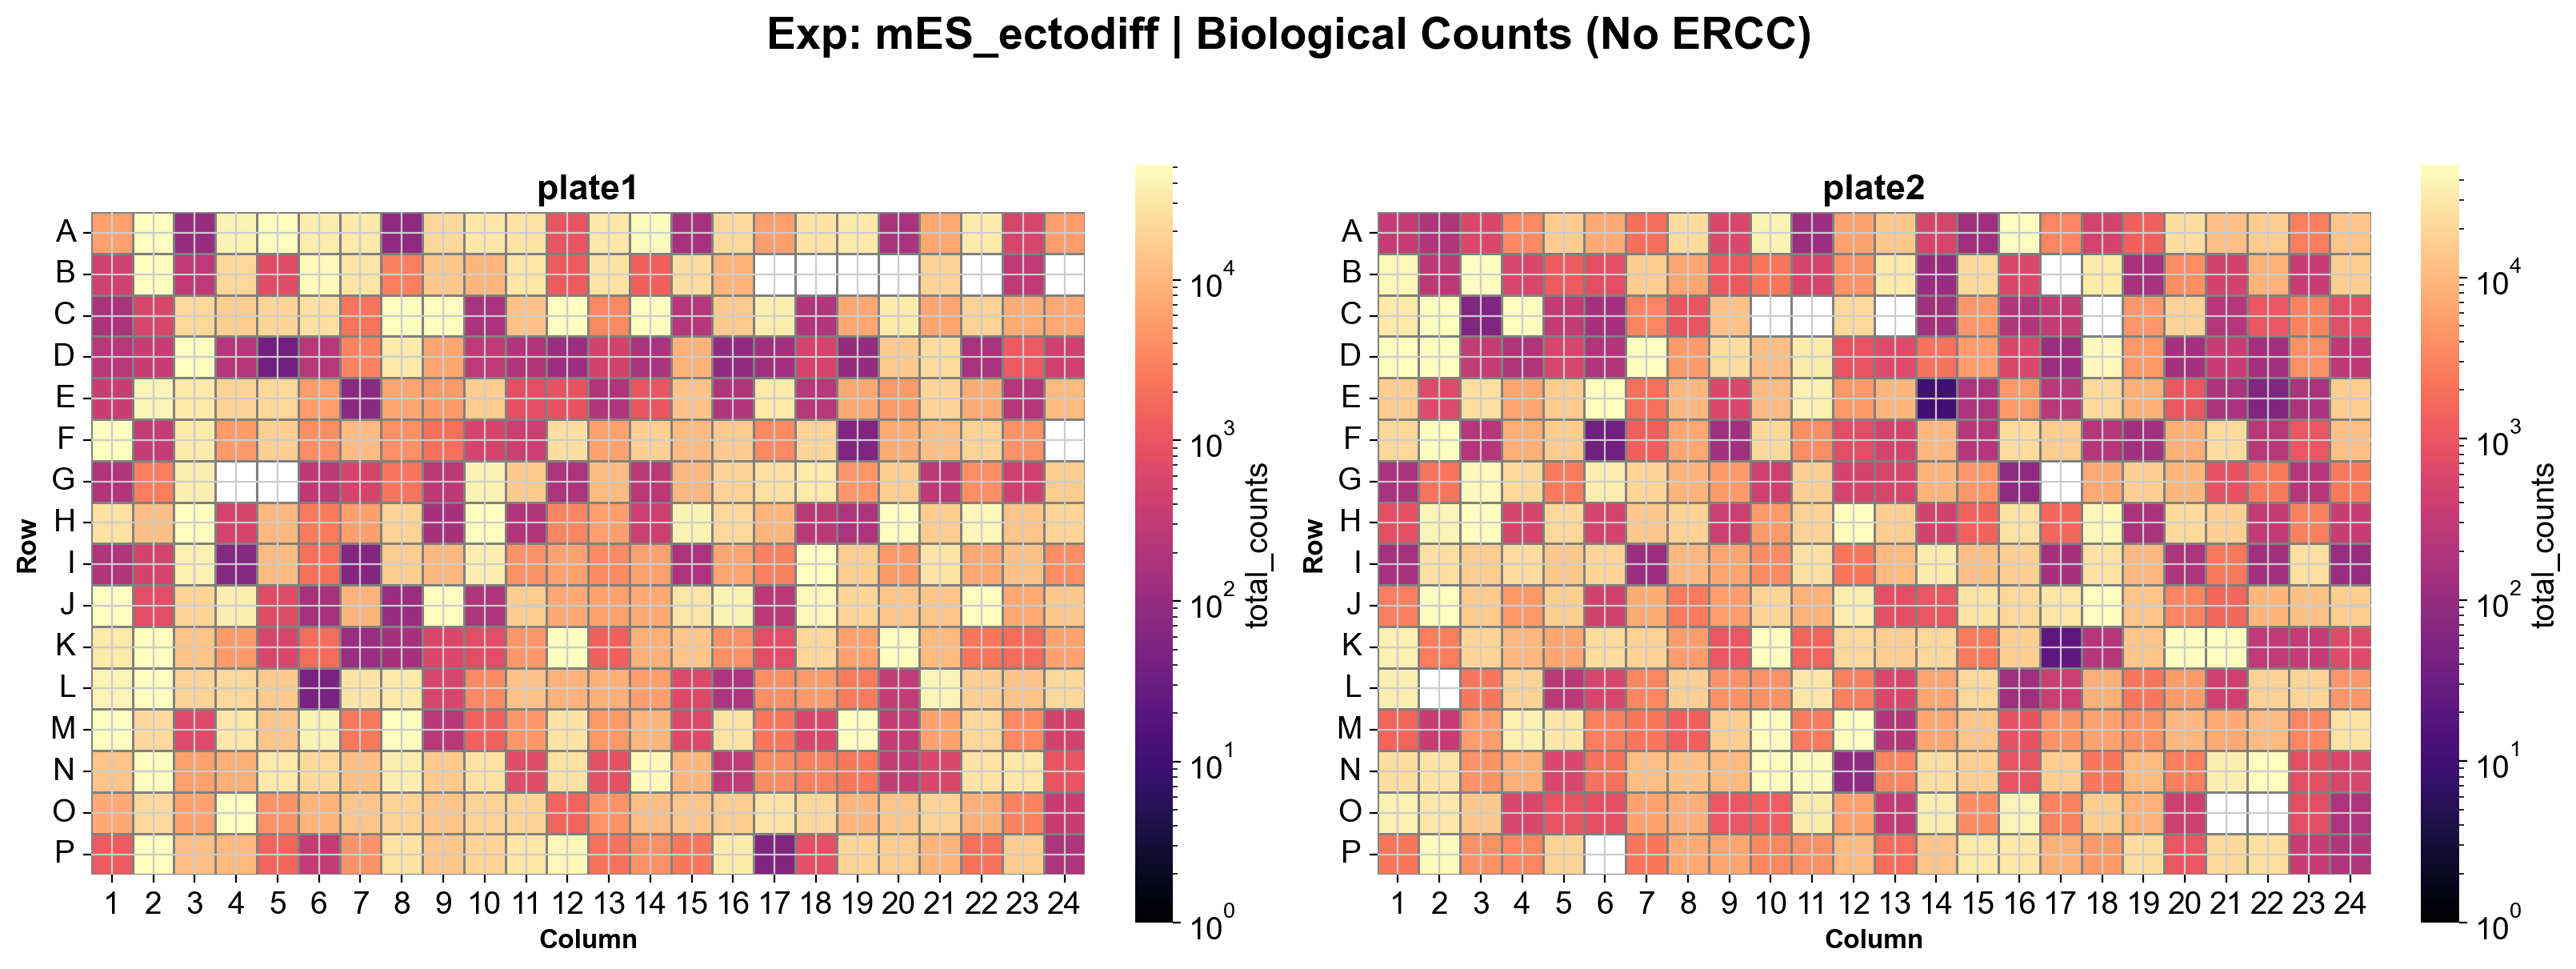

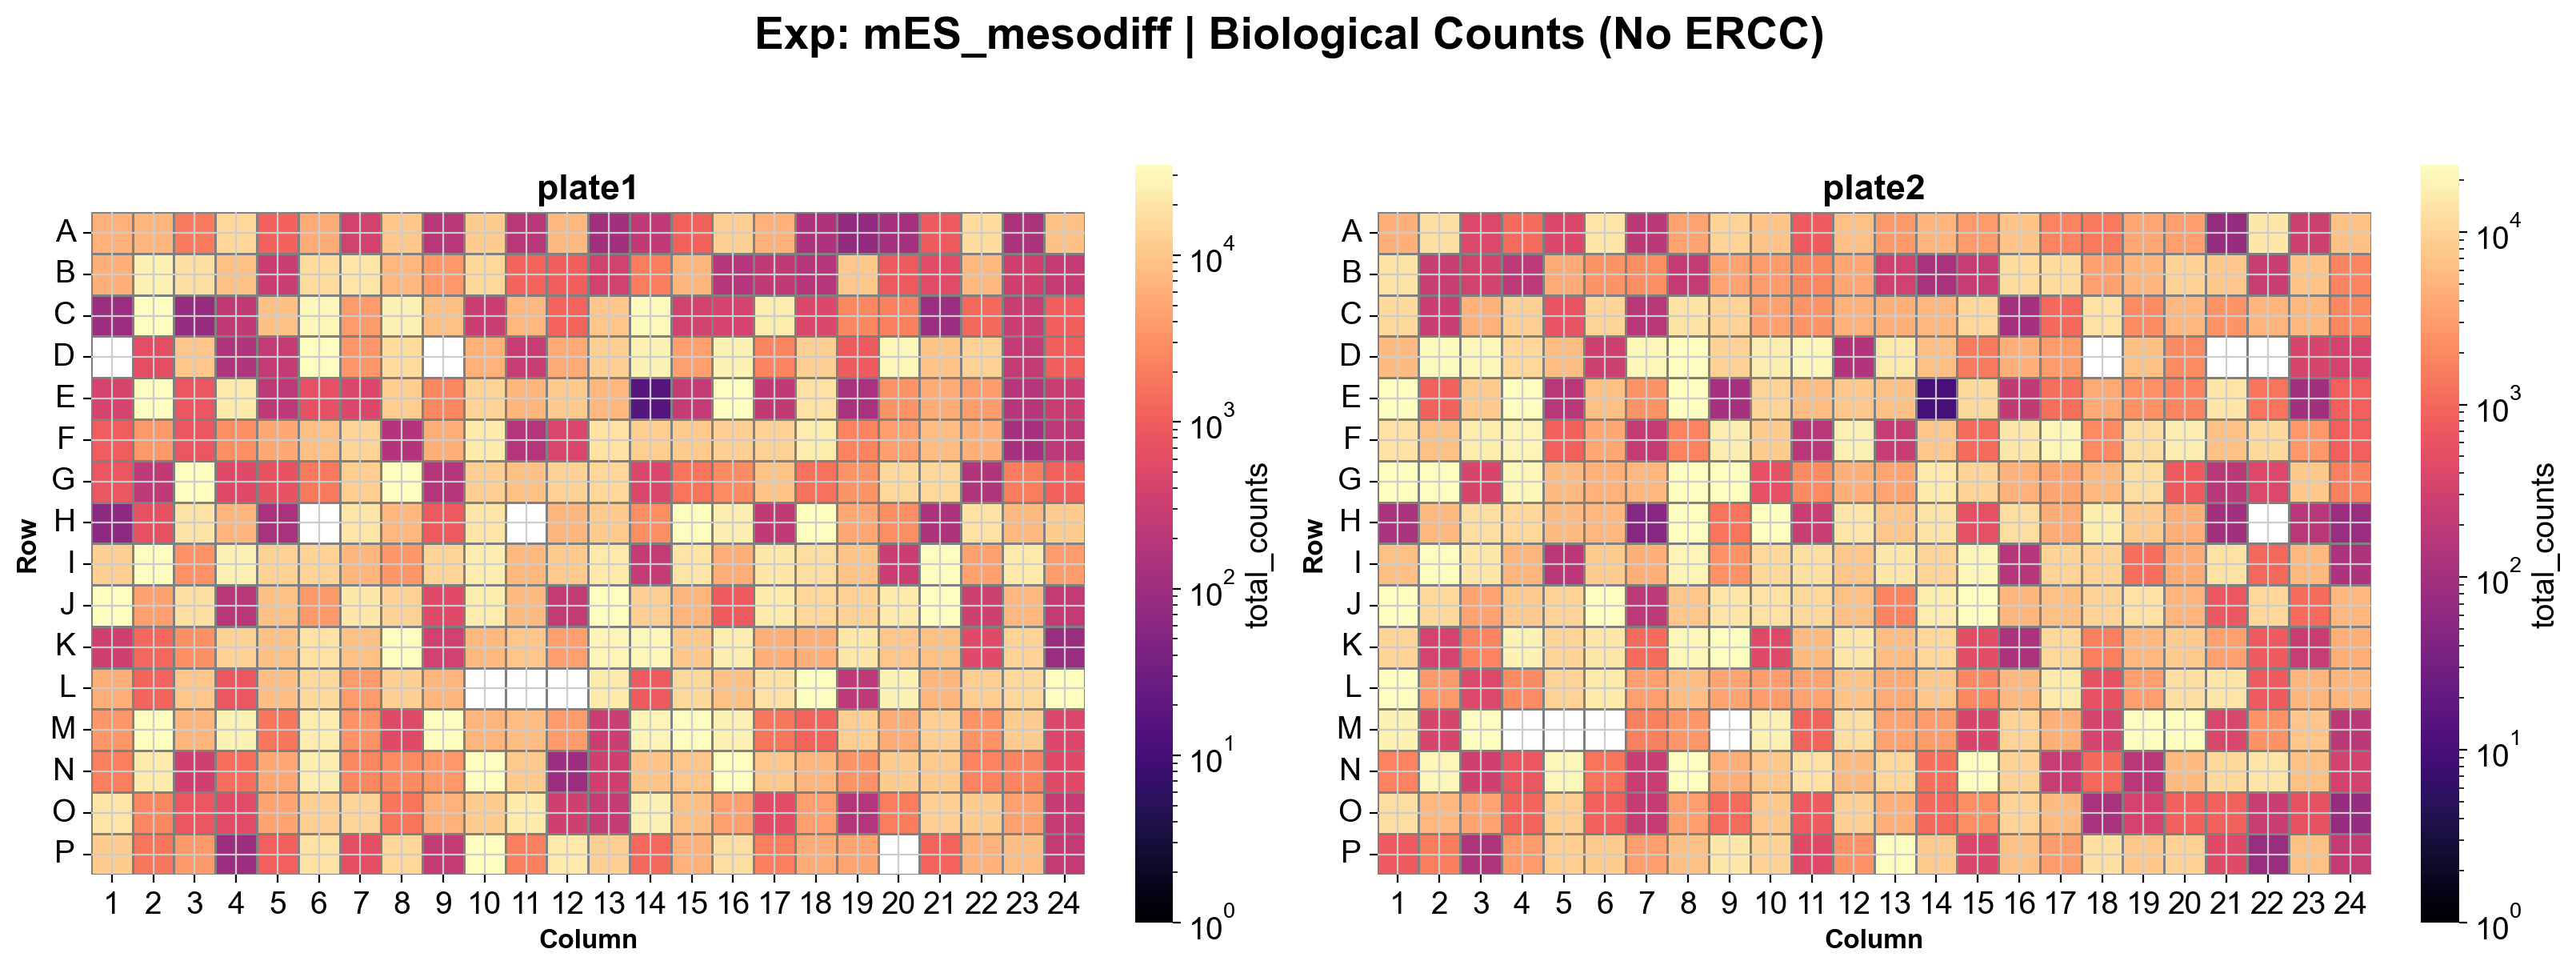

In [ ]:
# --- PLOT CLEAN DATA (Endogenous) ---
print("Generating Heatmaps for CLEAN data (Endogenous RNA only)...")
plot_plate_heatmap(adata, 'total_counts', title_suffix="Biological Counts (No ERCC)")

## FILTERING BACKGROUND BY NOISE

Empty wells show the background noise. We can discard cells with counts: 

1. < average noise of the empty wells + 3x standard deviation
2. < max(noise of empty wells)

NOTE: We are not filtering by empty wells for now since heavy noise...

In [ ]:
'''
# --- NOISE FLOOR ESTIMATION ---
# Extract Empty wells data
empty_obs = adata[adata.obs['sample_type'] == 'Empty'].obs

# Define noise threshold based on Empty wells statistics
# Using max() is conservative and safe for "ambient RNA" removal.
# Alternative: mean + 3*std_dev
ruido_max = empty_obs['total_counts'].max()
print(f"Noise floor determined by Empty wells: {ruido_max} counts")

# --- 3. HARD FILTERING (SIGNAL > NOISE) ---
# Keep only cells above noise floor AND remove the Empty wells themselves from the dataset
print(f"Cells before filtering: {adata.n_obs}")

# Combine logical masks: (Counts > Noise) AND (Type is NOT Empty)
mask_keep = (adata.obs['total_counts'] > ruido_max) & (adata.obs['sample_type'] != 'Empty')
adata = adata[mask_keep, :].copy() # Copy is important to free memory

print(f"Cells after noise filtering: {adata.n_obs}")
'''

'\n# --- NOISE FLOOR ESTIMATION ---\n# Extract Empty wells data\nempty_obs = adata[adata.obs[\'sample_type\'] == \'Empty\'].obs\n\n# Define noise threshold based on Empty wells statistics\n# Using max() is conservative and safe for "ambient RNA" removal.\n# Alternative: mean + 3*std_dev\nruido_max = empty_obs[\'total_counts\'].max()\nprint(f"Noise floor determined by Empty wells: {ruido_max} counts")\n\n# --- 3. HARD FILTERING (SIGNAL > NOISE) ---\n# Keep only cells above noise floor AND remove the Empty wells themselves from the dataset\nprint(f"Cells before filtering: {adata.n_obs}")\n\n# Combine logical masks: (Counts > Noise) AND (Type is NOT Empty)\nmask_keep = (adata.obs[\'total_counts\'] > ruido_max) & (adata.obs[\'sample_type\'] != \'Empty\')\nadata = adata[mask_keep, :].copy() # Copy is important to free memory\n\nprint(f"Cells after noise filtering: {adata.n_obs}")\n'

## HISTOGRAMS OVERVIEW

Histograms per experiment and plate to see low outliers to discard.

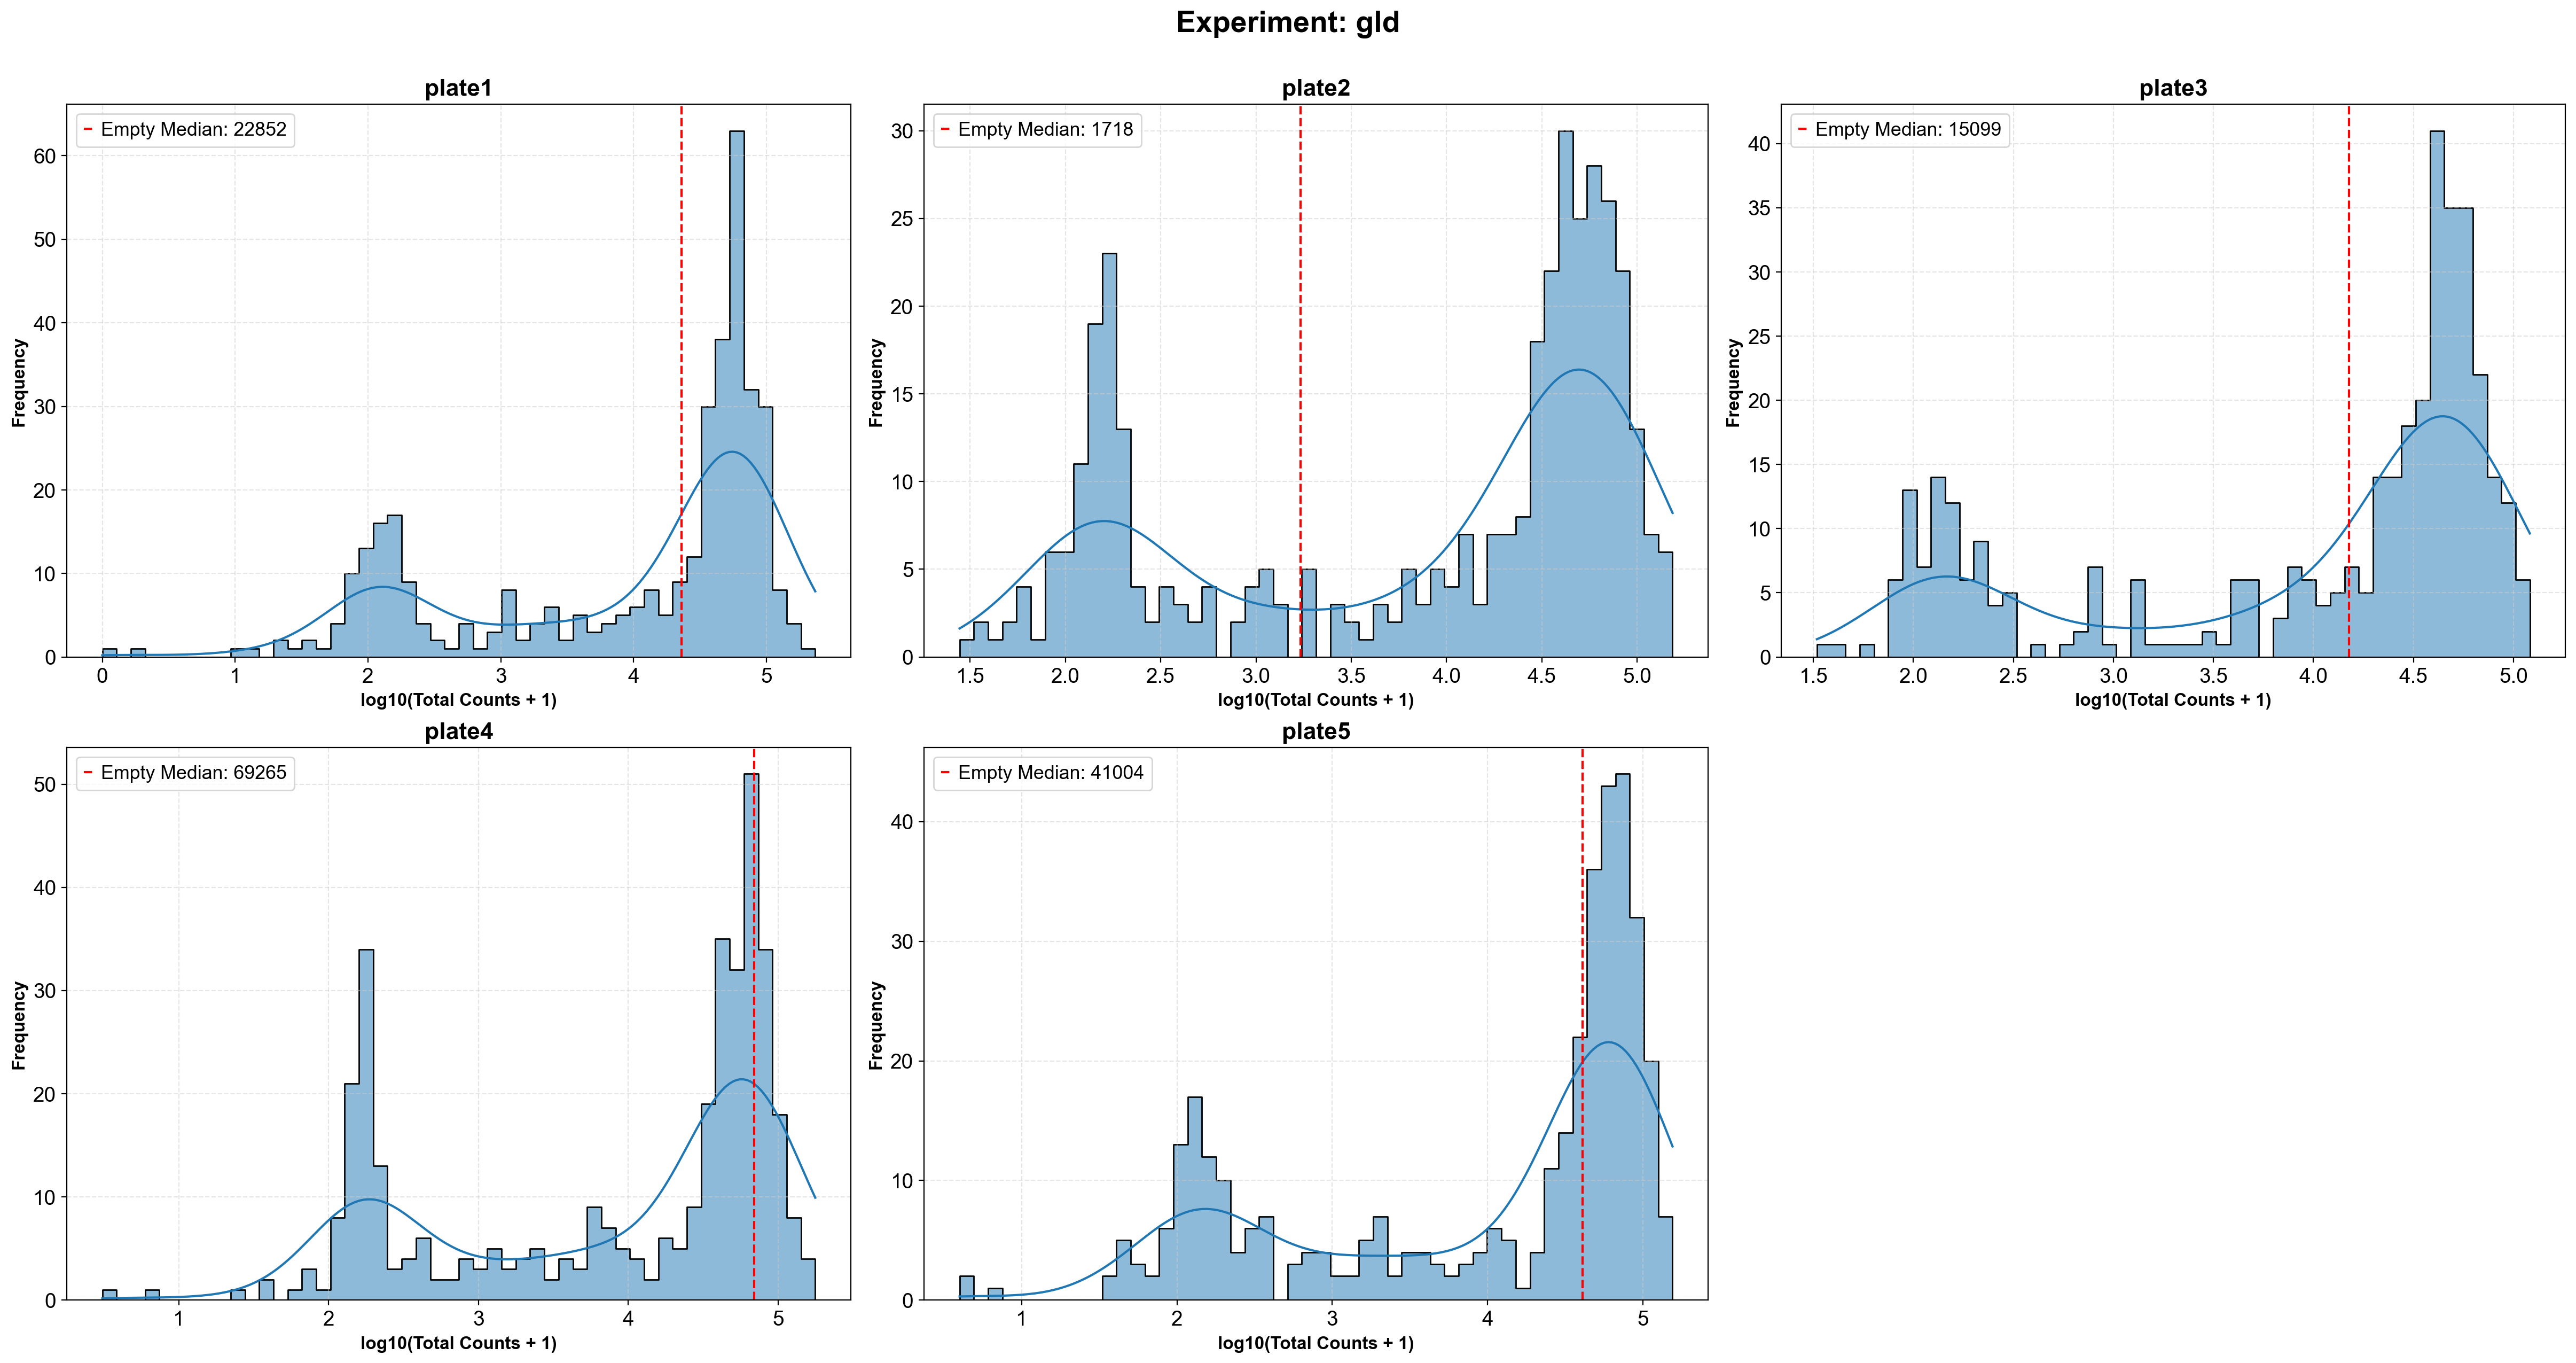

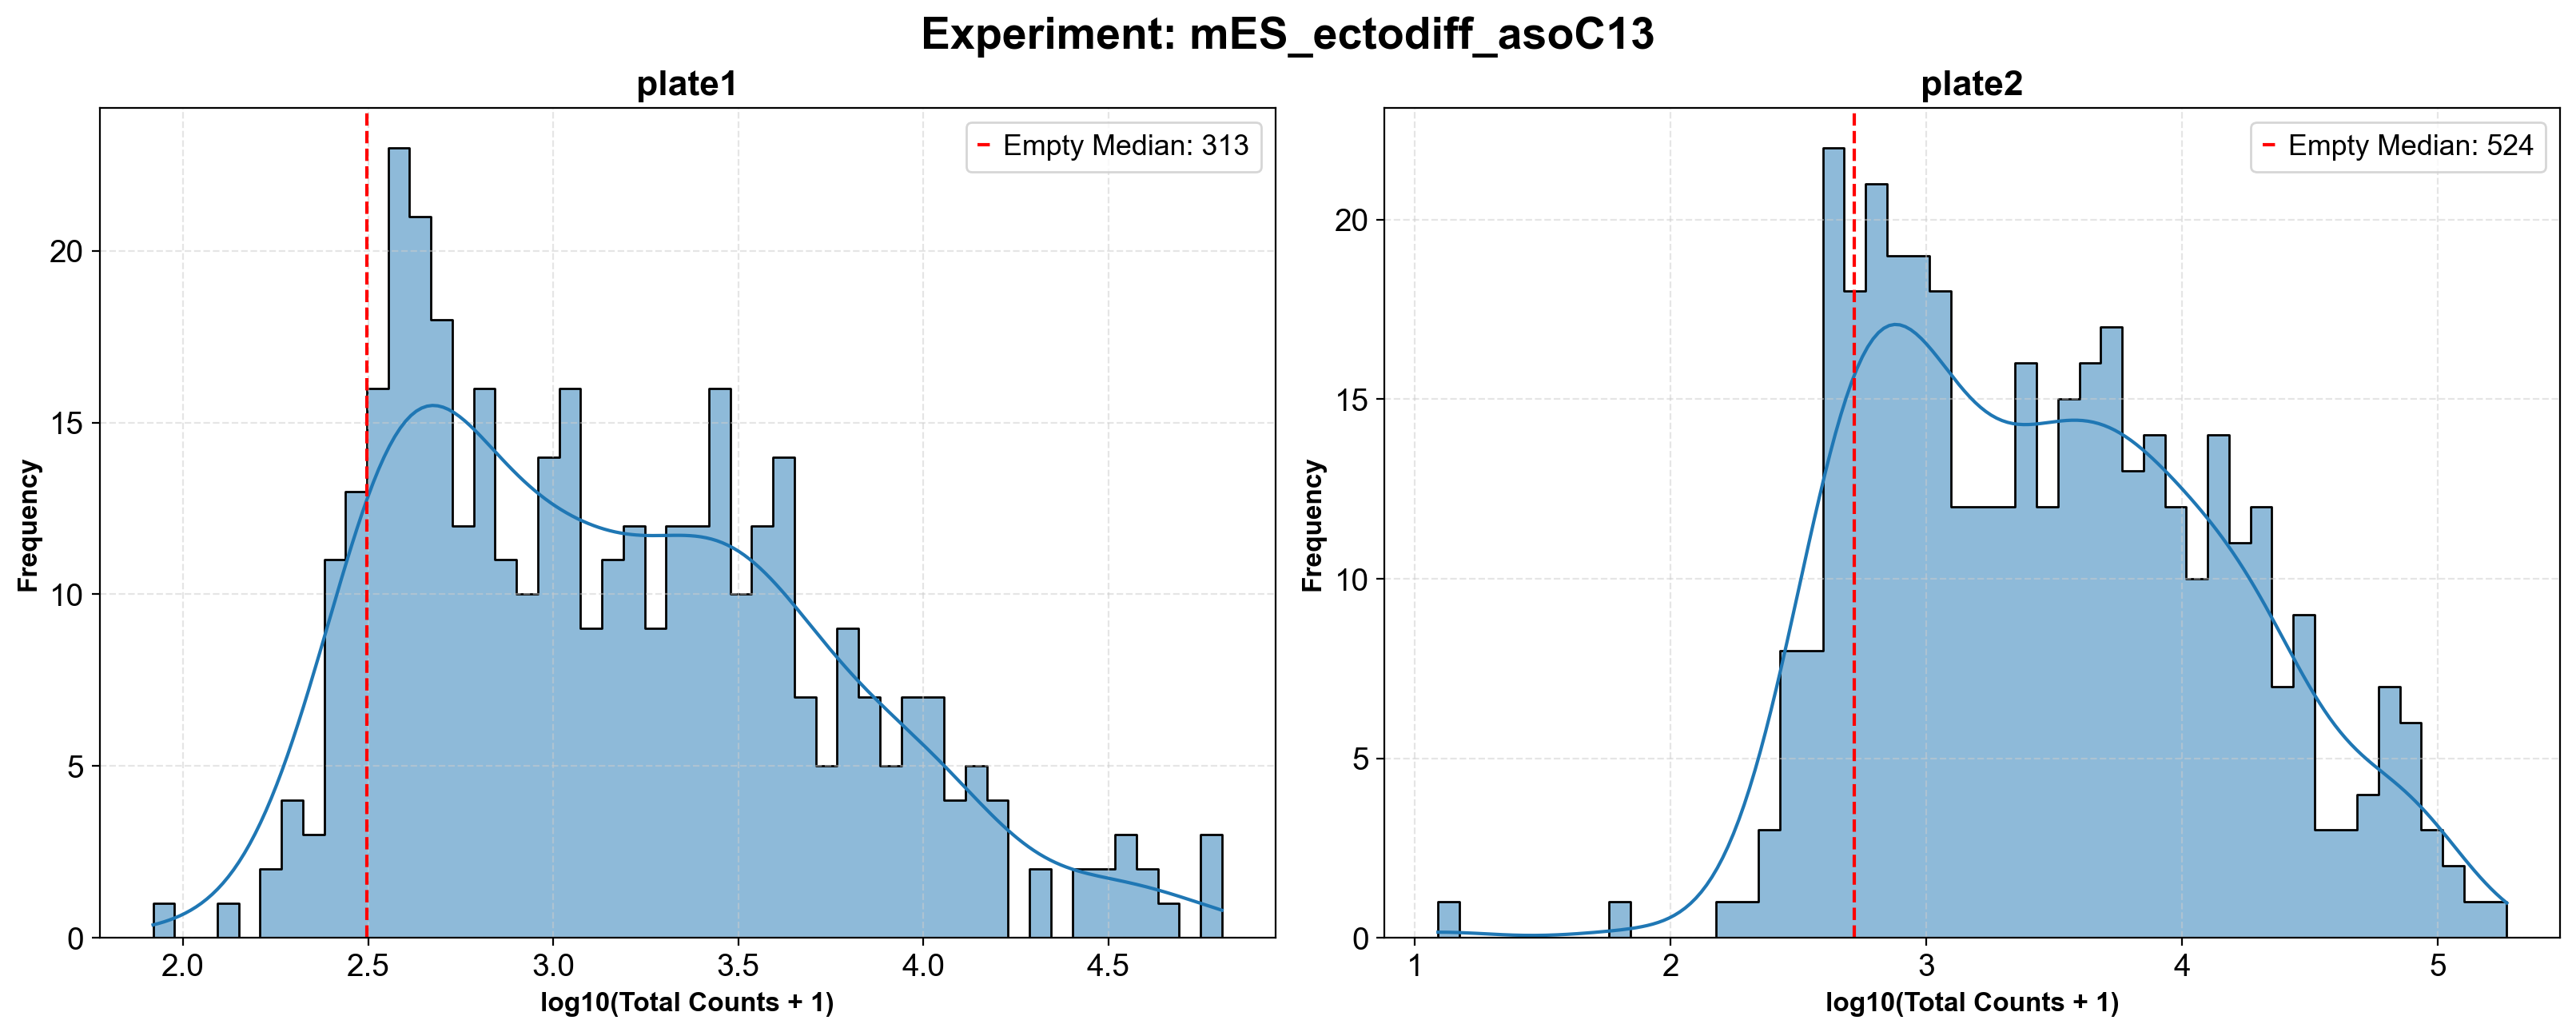

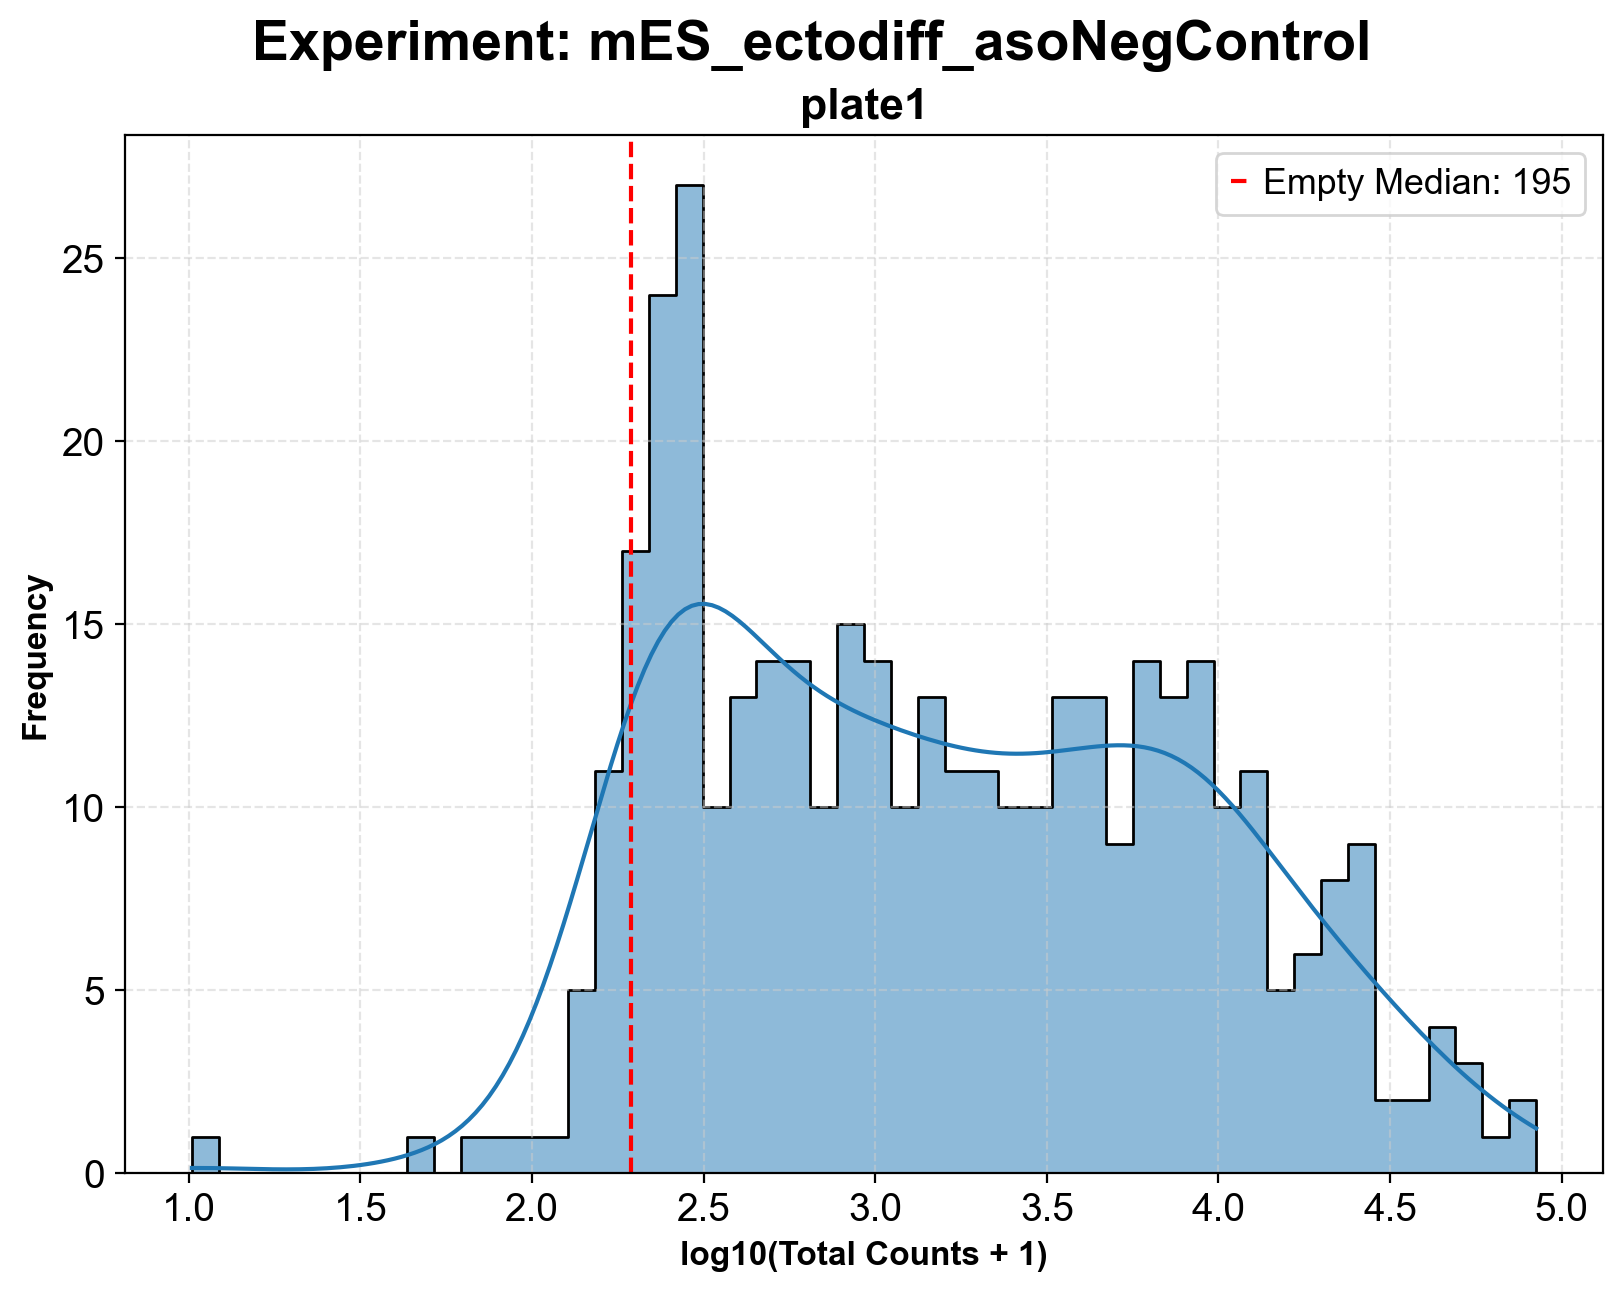

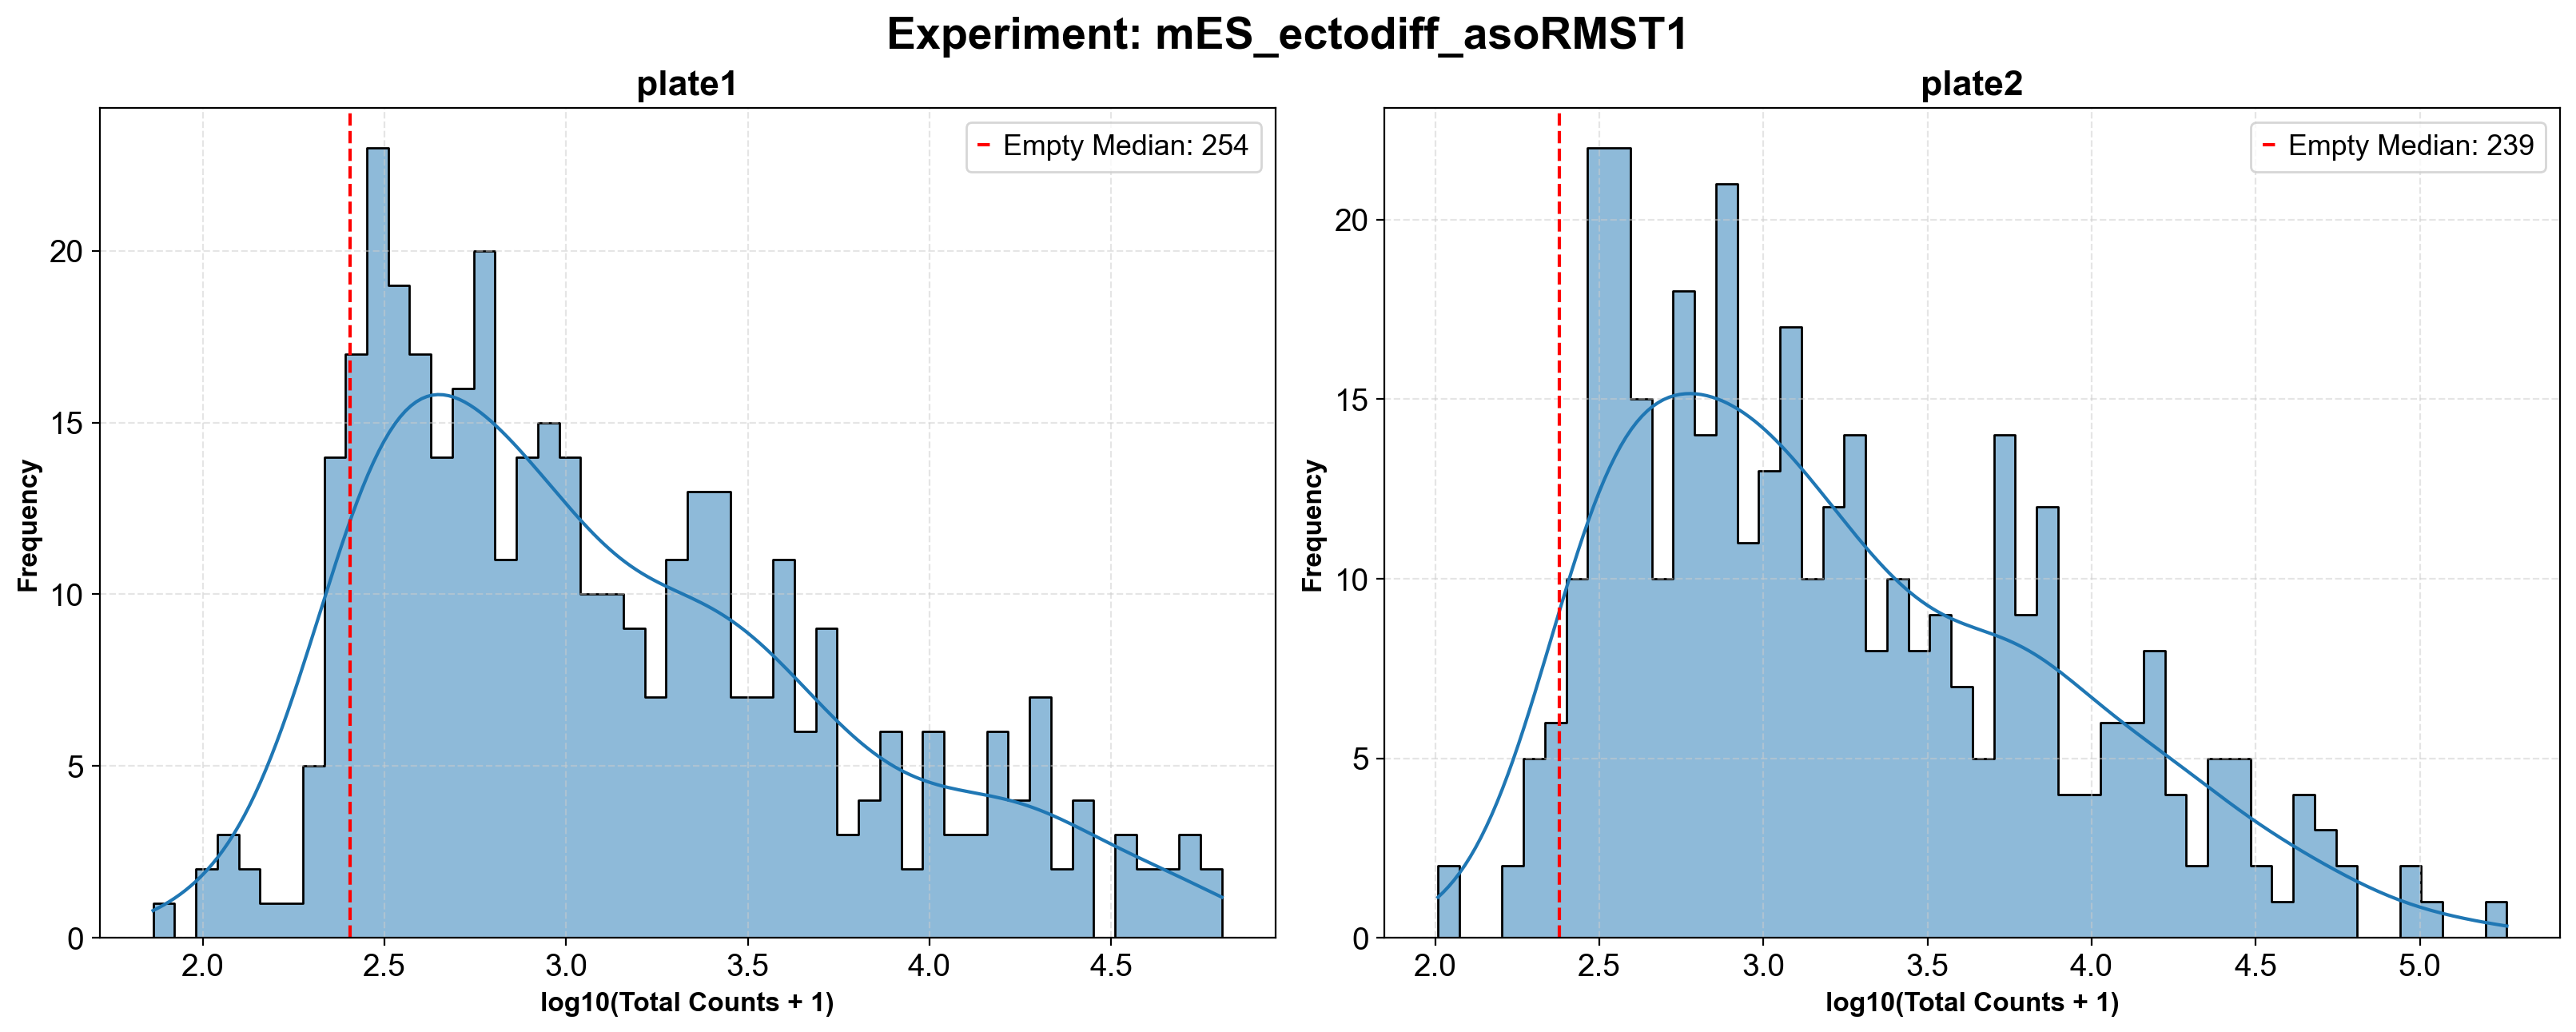

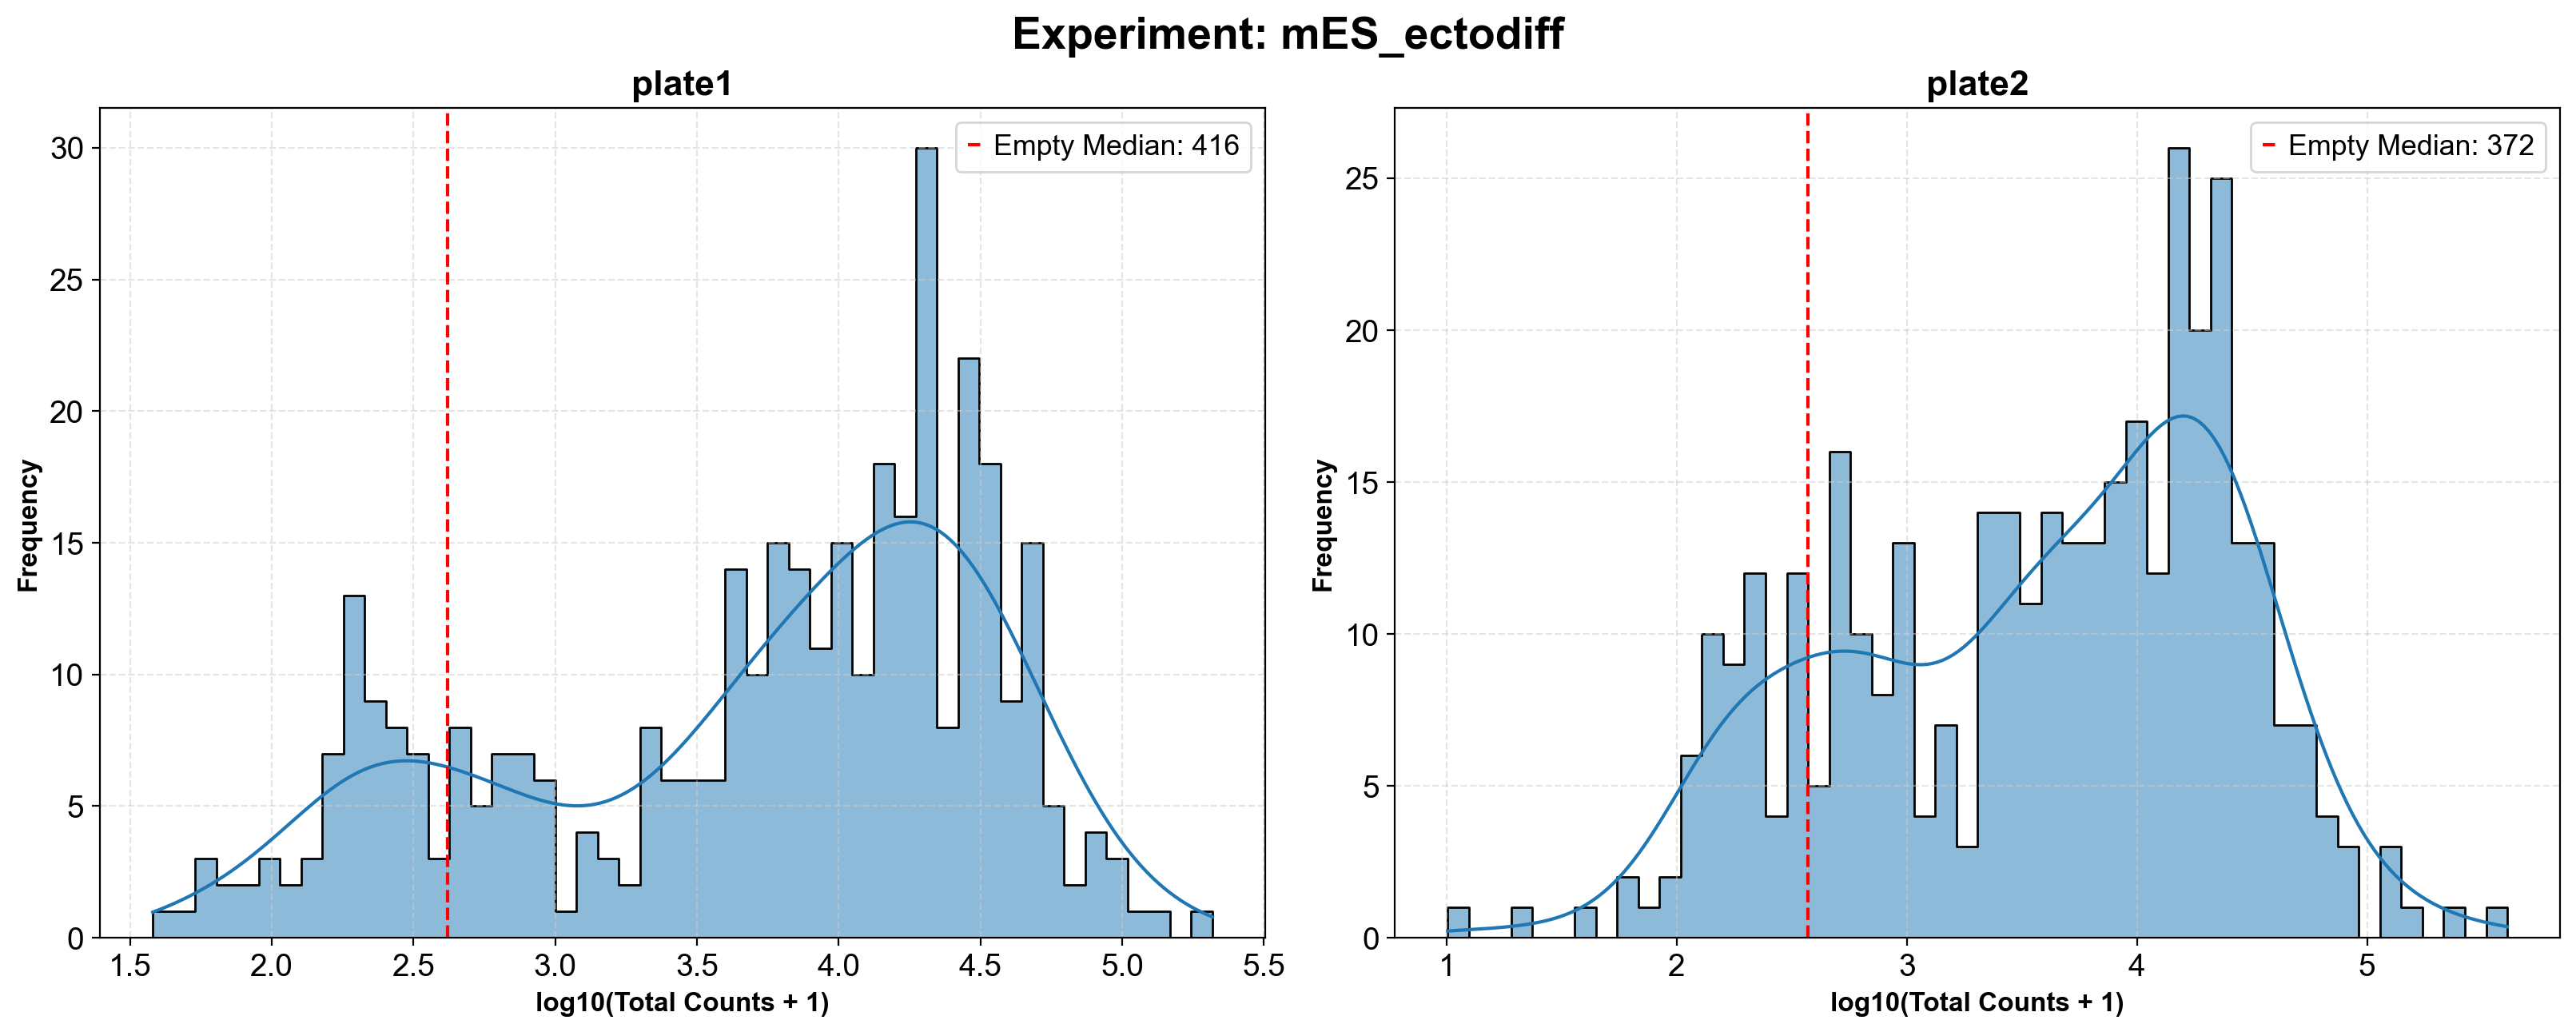

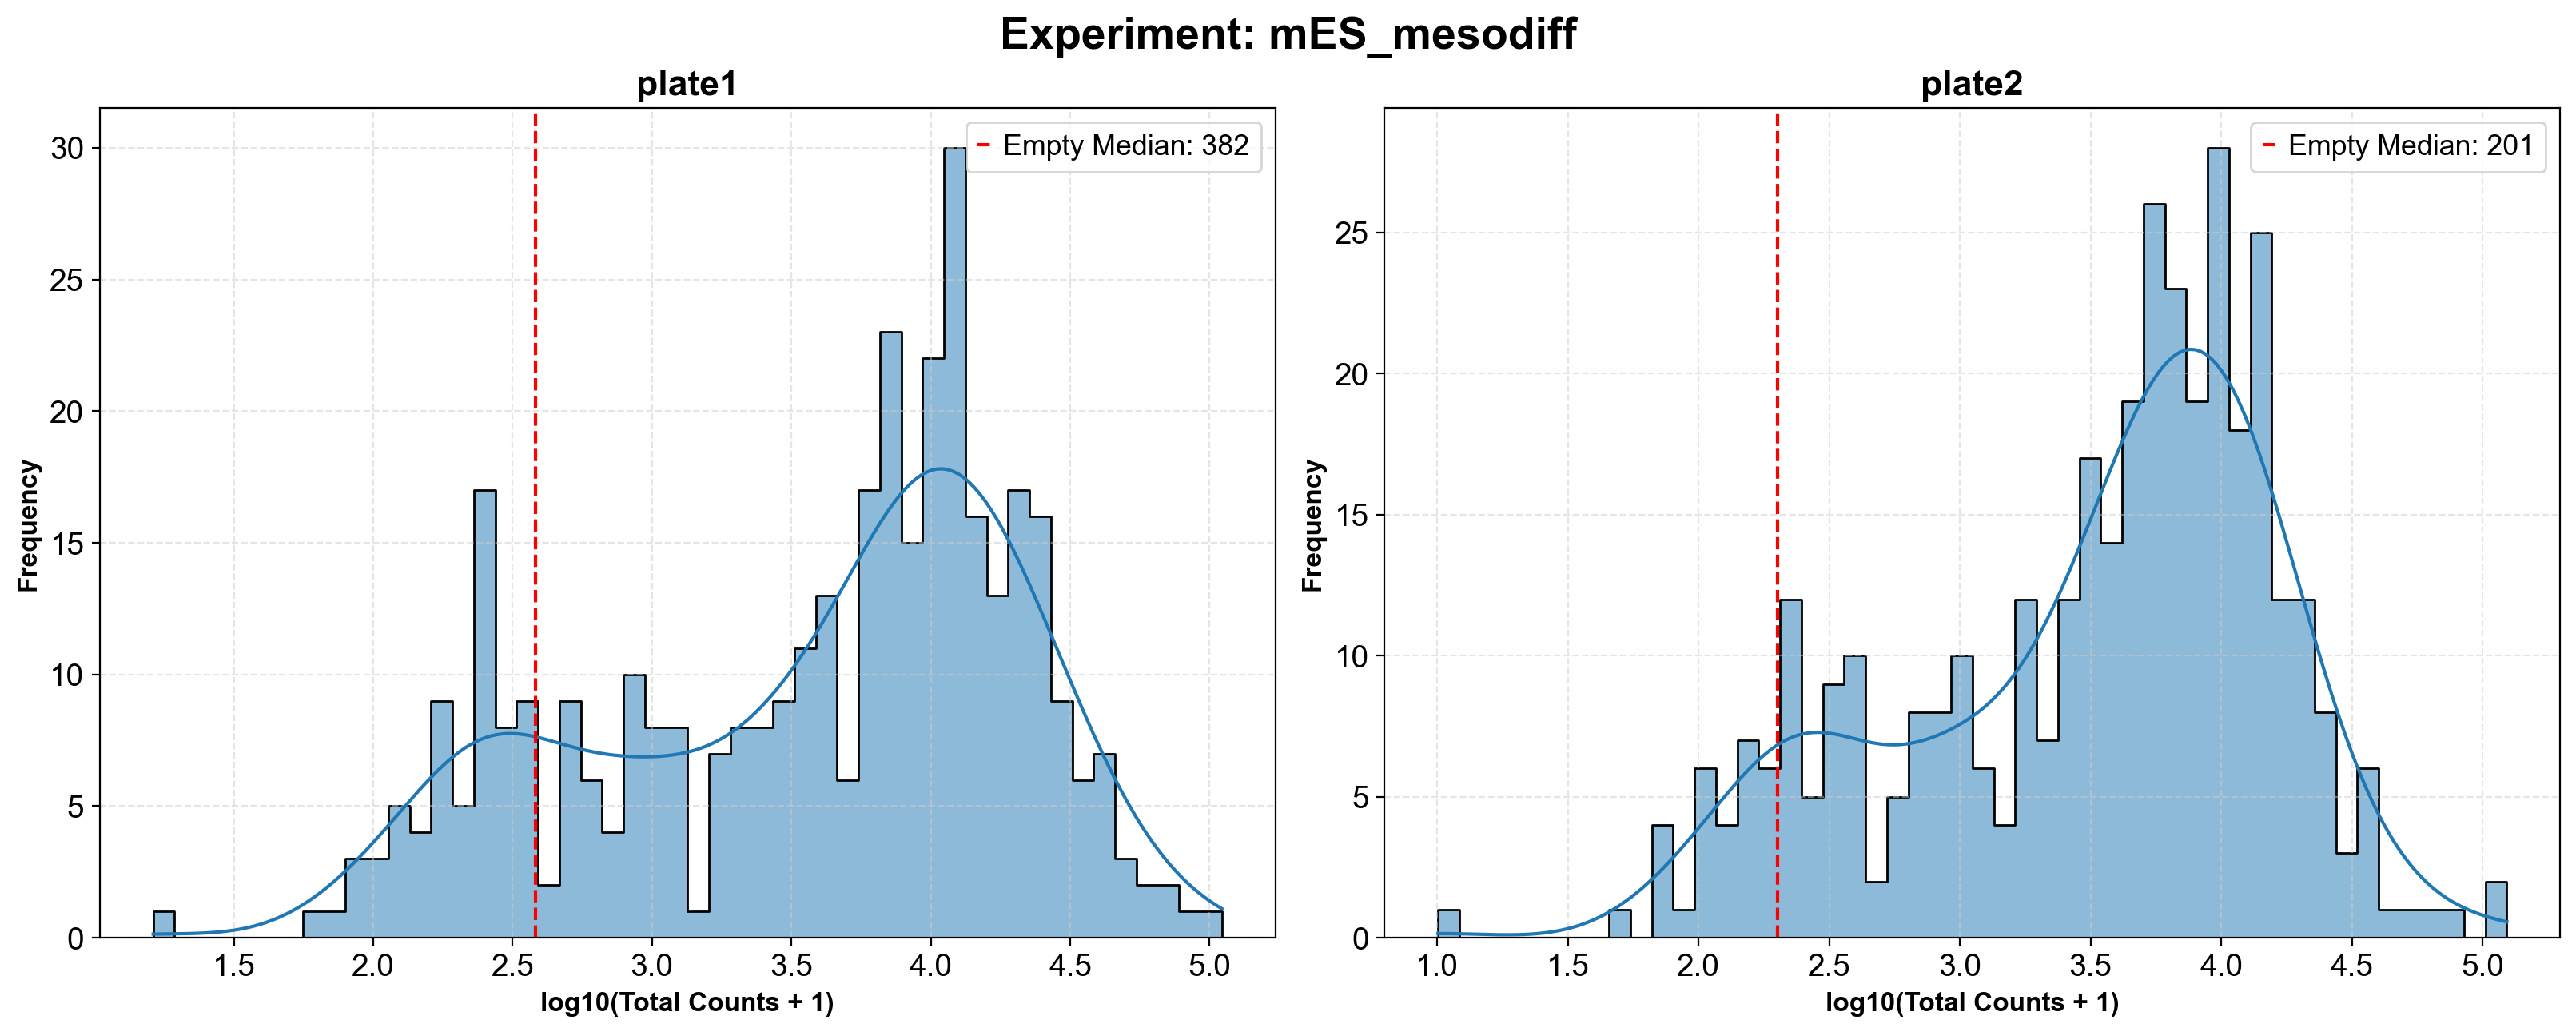

In [ ]:
# --- PLOTTING FUNCTION (Log-Histogram) ---
experiments = adata.obs['experiment'].unique()

for exp in experiments:
    # Filter data for current experiment
    subset = adata.obs[adata.obs['experiment'] == exp].copy()
    
    # Get plates and setup grid
    plates = sorted(subset['plate'].unique())
    n_plates = len(plates)
    n_cols = min(n_plates, 3)
    n_rows = math.ceil(n_plates / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows), constrained_layout=True)
    
    # Main Title
    fig.suptitle(f"Experiment: {exp}", 
                 fontsize=20, fontweight='bold', y=1.05)
    
    # Handle single subplot case
    if n_plates > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, plate in enumerate(plates):
        ax = axes[i]
        plate_data = subset[subset['plate'] == plate]
        
        # --- PHYSICS TRICK: Log transformation manually ---
        # Transforming data for plotting allows better control than just setting axis scale
        # log10(x + 1) to avoid log(0)
        data_to_plot = np.log10(plate_data['total_counts'] + 1)
        
        # Plot Histogram
        # hue='sample_type': This separates Empty vs mESC vs Sample visually
        sns.histplot(
            data=plate_data,
            x=data_to_plot,
            multiple='stack',     # Stack them to see total distribution
            bins=50,              # Resolution
            ax=ax,
            kde=True,             # Add density line
            element='step'
        )
        
        # --- AESTHETICS ---
        ax.set_title(f"{plate}", fontsize=16, fontweight='bold')
        ax.set_xlabel("log10(Total Counts + 1)", fontsize=12, fontweight='bold')
        ax.set_ylabel("Frequency", fontsize=12, fontweight='bold')
        
        # Grid for easier reading of values
        ax.grid(True, which="both", ls="--", alpha=0.5)

        # Add vertical lines for reference (Optional statistics)
        # Median of Empty wells (if present)
        if 'Empty' in plate_data['sample_type'].values:
            median_noise = np.log10(plate_data[plate_data['sample_type'] == 'Empty']['total_counts'].median() + 1)
            ax.axvline(median_noise, color='red', linestyle='--', label=f'Empty Median: {10**median_noise:.0f}')
            ax.legend()

    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

## FINDING THRESHOLD FROM HISTOGRAMS

Note: Normally less than 500 counts is not a good read.

1. Bimodal distributions: valley for cut-off
2. Unimodal distributions: use the mean of the rest of 'similar experiments' (i.e. no gastruloids one) to set the threshold

Detected 14 unique (Experiment, Plate) combinations.
--- STARTING CALIBRATION ---
Found Valley for gld-plate1: 1085
Found Valley for gld-plate2: 1972
Found Valley for gld-plate3: 1350
Found Valley for gld-plate4: 1549
Found Valley for gld-plate5: 2207
Found Valley for mES_ectodiff_asoC13-plate1: 1871
Found Valley for mES_ectodiff_asoC13-plate2: 2441
Found Valley for mES_ectodiff_asoNegControl-plate1: 2584
Found Valley for mES_ectodiff-plate1: 1193
Found Valley for mES_ectodiff-plate2: 1148
Found Valley for mES_mesodiff-plate1: 938
Found Valley for mES_mesodiff-plate2: 559


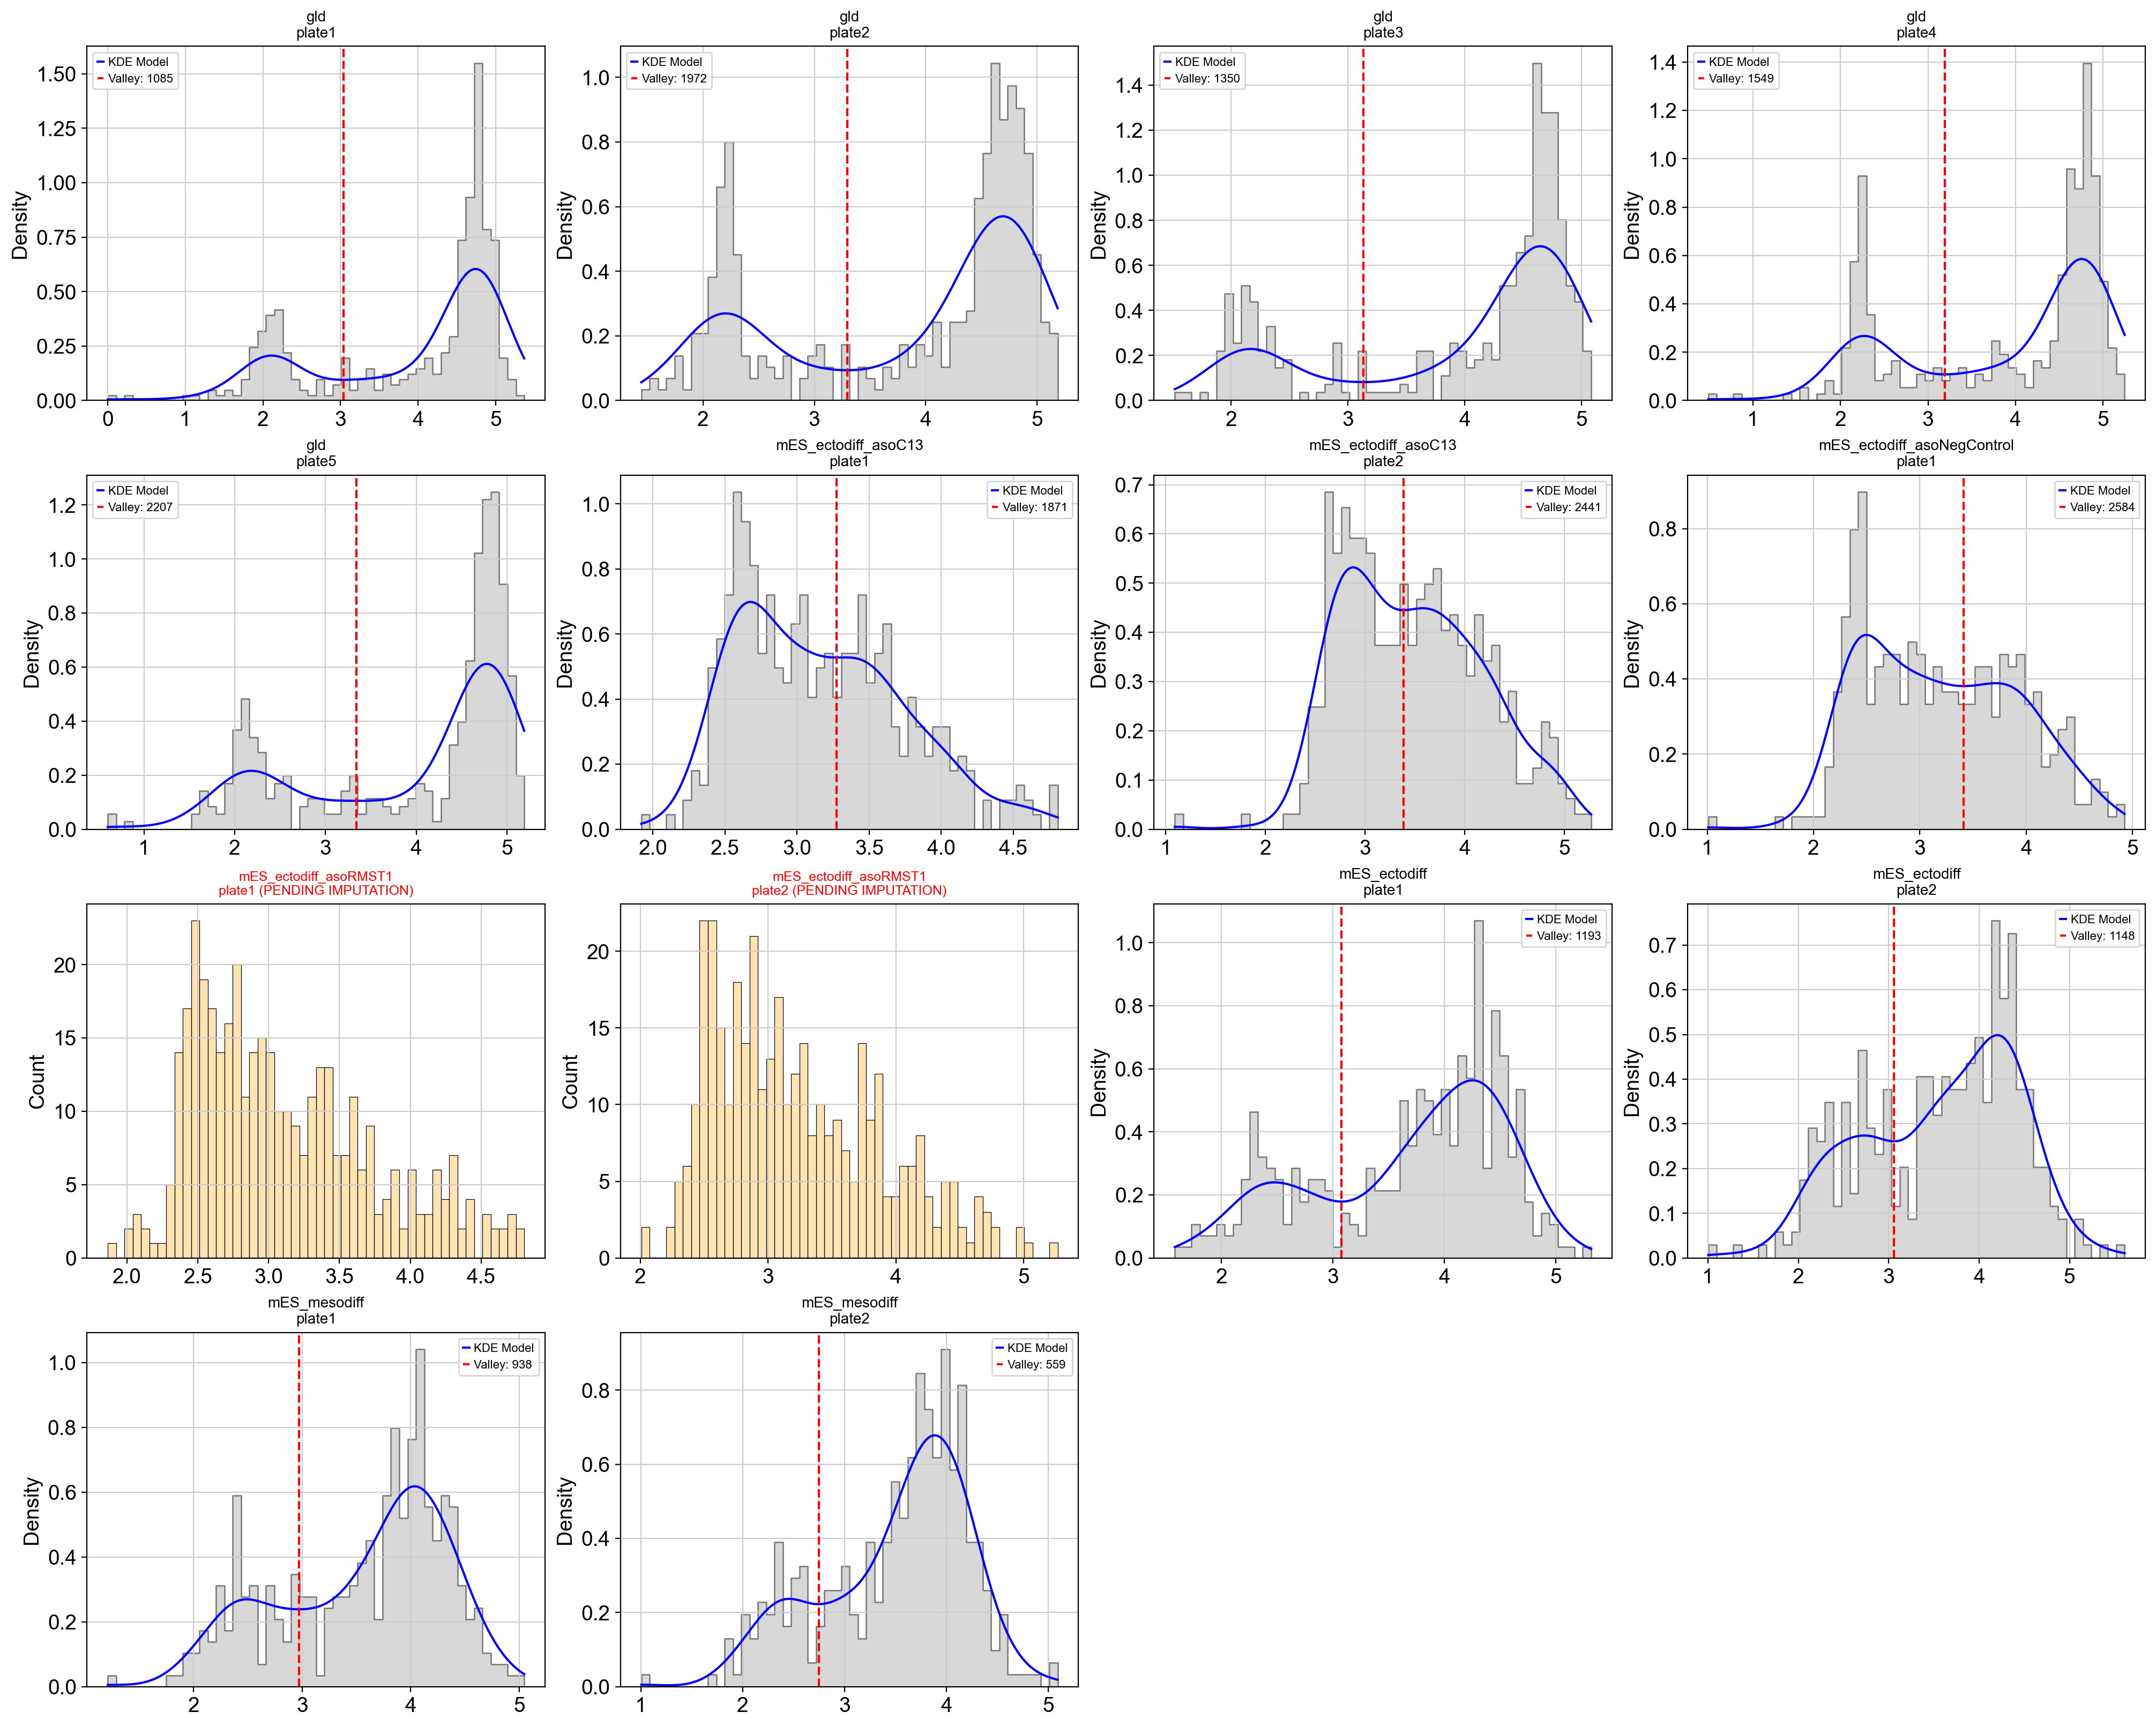

In [ ]:
def find_valley_physics(counts, title="", ax=None):
    """
    Analytically finds the local minimum (valley) between noise and signal.
    """
    # 1. Log-transform (Essential for power-law distributions)
    # Adding +1 to avoid log(0)
    data_log = np.log10(counts + 1)
    
    # 2. Kernel Density Estimation (Continuous PDF approximation)
    kde = gaussian_kde(data_log)
    x_grid = np.linspace(data_log.min(), data_log.max(), 1000)
    y_curve = kde(x_grid)
    
    # 3. Find local minima (The Valley)
    # We look for points where derivative is zero and convex
    minima_indices = argrelextrema(y_curve, np.less)[0]
    
    valley_log = None
    
    # Logic to select the "true" valley (phase transition)
    # We ignore minima at the very edges (tails)
    valid_minima = [x_grid[i] for i in minima_indices if 1.5 < x_grid[i] < 4.5]
    
    if len(valid_minima) > 0:
        # If multiple, take the one with lowest density (deepest cut)
        # Usually corresponds to the best separation
        valley_log = valid_minima[np.argmin(kde(valid_minima))]
    
    # --- PLOTTING FOR VISUAL CHECK ---
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.histplot(data_log, bins=50, stat='density', alpha=0.3, color='gray', ax=ax, element="step")
    ax.plot(x_grid, y_curve, 'b-', label='KDE Model')
    
    if valley_log:
        ax.axvline(valley_log, color='r', linestyle='--', label=f'Valley: {10**valley_log:.0f}')
    else:
        ax.text(0.5, 0.5, "UNIMODAL (No Valley)", transform=ax.transAxes, color='red', ha='center')
        
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=8)
    
    # Return linear value or None
    return 10**valley_log if valley_log else None

# --- CONFIGURATION ---
bad_experiment = 'mES_ectodiff_asoRMST1'
gld_experiment = 'gld'

thresholds_map = {}      
reference_values = []    

experiments = adata.obs['experiment'].unique()

# --- CORRECT GRID CALCULATION (PHYSICS FIX) ---
# We need to count total (Experiment, Plate) combinations, not just unique plate names.
# Pandas drop_duplicates on the pair gives the true number of subplots needed.
total_plots = len(adata.obs[['experiment', 'plate']].drop_duplicates())

print(f"Detected {total_plots} unique (Experiment, Plate) combinations.")

# Setup Grid
n_cols = 4
n_rows = math.ceil(total_plots / n_cols)

# Create Figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), constrained_layout=True)

# Flatten axes array for 1D iteration. 
# Robust check: if n_rows=1 and n_cols=1, axes is not an array, so we wrap it.
if total_plots > 1:
    axes = axes.flatten()
else:
    axes = [axes]

ax_idx = 0

print("--- STARTING CALIBRATION ---")

for exp in experiments:
    # Get plates for this experiment
    plates = sorted(adata.obs[adata.obs['experiment'] == exp]['plate'].unique())
    
    for plate in plates:
        # Get data
        subset = adata.obs[(adata.obs['experiment'] == exp) & (adata.obs['plate'] == plate)]
        counts = subset['total_counts'].values
        
        ax = axes[ax_idx]
        
        # --- LOGIC BRANCHING ---
        
        if exp == bad_experiment:
            # Case 1: Unimodal/Bad experiment. 
            # We DO NOT calculate valley here. We mark it as None for imputation later.
            thresholds_map[(exp, plate)] = None
            
            # Just plot histogram for reference
            sns.histplot(np.log10(counts+1), bins=50, color='orange', alpha=0.3, ax=ax)
            ax.set_title(f"{exp}\n{plate} (PENDING IMPUTATION)", fontsize=9, color='red')
            
        else:
            # Case 2: Bimodal (Standard or Gastruloid)
            # Try to find the valley analytically
            val = find_valley_physics(counts, title=f"{exp}\n{plate}", ax=ax)
            
            if val is not None:
                thresholds_map[(exp, plate)] = val
                print(f"Found Valley for {exp}-{plate}: {val:.0f}")
                
                # CRITICAL: Only add to reference mean if it's NOT gastruloid
                if exp != gld_experiment:
                    reference_values.append(val)
            else:
                # If algorithm fails on a "good" plate, we will also impute
                thresholds_map[(exp, plate)] = None
                print(f"WARNING: No valley found for {exp}-{plate}. Will impute.")

        ax_idx += 1

# Hide unused axes
for i in range(ax_idx, len(axes)):
    axes[i].axis('off')

plt.show()

In [ ]:
# --- IMPUTATION LOGIC ---

# 1. Calculate the robust mean from the "Good" plates
if len(reference_values) > 0:
    mean_threshold = np.mean(reference_values)
    print(f"\n--- CALIBRATION RESULTS ---")
    print(f"Reference Thresholds found: {[int(v) for v in reference_values]}")
    print(f"Calculated Mean Threshold: {mean_threshold:.0f} counts")
else:
    # Failsafe if everything failed (unlikely)
    print("CRITICAL: No valid valleys found anywhere. Defaulting to 500.")
    mean_threshold = 500

# 2. Assign the mean to the missing plates (Imputation)
for key, val in thresholds_map.items():
    if val is None:
        # This catches 'asoRMST1' and any other failed fit
        thresholds_map[key] = mean_threshold
        print(f"Imputing {mean_threshold:.0f} for {key[0]} - {key[1]}")


--- CALIBRATION RESULTS ---
Reference Thresholds found: [1870, 2441, 2584, 1193, 1148, 938, 558]
Calculated Mean Threshold: 1533 counts
Imputing 1533 for mES_ectodiff_asoRMST1 - plate1
Imputing 1533 for mES_ectodiff_asoRMST1 - plate2


## Filtering data under the calculated thresholds

In [ ]:
# --- APPLY FILTER ---

print("\n--- APPLYING FILTERS ---")
# Create a False mask
keep_mask = np.zeros(adata.n_obs, dtype=bool)

for exp in experiments:
    plates = adata.obs[adata.obs['experiment'] == exp]['plate'].unique()
    for plate in plates:
        # Get specific threshold
        thr = thresholds_map[(exp, plate)]
        
        # Build mask for this plate
        plate_mask = (adata.obs['experiment'] == exp) & \
                     (adata.obs['plate'] == plate) & \
                     (adata.obs['total_counts'] > thr)
        
        # Combine with global mask
        keep_mask = keep_mask | plate_mask

# Execute filtering
n_before = adata.n_obs
adata = adata[keep_mask, :].copy()
n_after = adata.n_obs

print(f"Filtering Complete.")
print(f"Before: {n_before} -> After: {n_after} cells")
print(f"Removed {n_before - n_after} cells ({((n_before-n_after)/n_before)*100:.1f}%)")

# --- SAVE FILTERED RAW DATA ---

# 1. Verification before saving
print(f"Saving object with {adata.n_obs} cells and {adata.n_vars} genes.")

# 2. Optimization: Remove Unused Categories
# Since we filtered cells, some 'plate' or 'experiment' categories might be empty.
# We clean metadata to save space and avoid errors later.
for col in adata.obs.columns:
    if adata.obs[col].dtype.name == 'category':
        adata.obs[col] = adata.obs[col].cat.remove_unused_categories()

# 3. Save to disk (Compressed)
# .h5ad is the HDF5 format for AnnData. Compression reduces disk size significantly.
adata.write("data_filtered_raw.h5ad", compression="gzip")

print("SUCCESS: Data saved to 'data_filtered_raw.h5ad'.")
print("ACTION: Now restart your Kernel (Kernel -> Restart) to free RAM.")


--- APPLYING FILTERS ---
Filtering Complete.
Before: 3311 -> After: 3311 cells
Removed 0 cells (0.0%)
Saving object with 3311 cells and 244105 genes.
SUCCESS: Data saved to 'data_filtered_raw.h5ad'.
ACTION: Now restart your Kernel (Kernel -> Restart) to free RAM.
